# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform, spearmanr
from sklearn.model_selection import (
    train_test_split, cross_val_score, cross_val_predict, learning_curve, 
    GridSearchCV, RandomizedSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    matthews_corrcoef
)

import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

# Display full dataframes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set random seed
random_seed = 42

# Data Preprocessing

In [7]:
# Load data visit 1
test_df_visit1 = pd.read_csv("../data/test_df_imputed_1stvisit.csv")
train_df_visit1 = pd.read_csv("../data/train_df_imputed_1stvisit.csv")

# Load data visit 2
test_df_visit2 = pd.read_csv("../data/test_df_imputed_2ndvisit.csv")
train_df_visit2 = pd.read_csv("../data/train_df_imputed_2ndvisit.csv")

# Load data visit 3
test_df_visit3 = pd.read_csv("../data/test_df_imputed_3rdvisit.csv")
train_df_visit3 = pd.read_csv("../data/train_df_imputed_3rdvisit.csv")

# Create copies of the original dataframes
test_df_visit1_copy = test_df_visit1.copy()
train_df_visit1_copy = train_df_visit1.copy()
test_df_visit2_copy = test_df_visit2.copy()
train_df_visit2_copy = train_df_visit2.copy()
test_df_visit3_copy = test_df_visit3.copy()
train_df_visit3_copy = train_df_visit3.copy()

In [9]:
# Add VisitNuA column
test_df_visit1["VisitNuA"] = 1
train_df_visit1["VisitNuA"] = 1
test_df_visit2["VisitNuA"] = 2
train_df_visit2["VisitNuA"] = 2
test_df_visit3["VisitNuA"] = 3
train_df_visit3["VisitNuA"] = 3

# Ensure consistent column order across all visits
all_columns = list(
    set(test_df_visit1.columns)
    .union(set(test_df_visit2.columns))
    .union(set(test_df_visit3.columns))
)

# Add missing columns to visit3 datasets
for col in all_columns:
    if col not in test_df_visit3.columns:
        test_df_visit3[col] = 999
    if col not in train_df_visit3.columns:
        train_df_visit3[col] = 999

# Add missing columns to visit1 and visit2 datasets
for col in all_columns:
    if col not in test_df_visit1.columns:
        test_df_visit1[col] = 999
    if col not in train_df_visit1.columns:
        train_df_visit1[col] = 999
    if col not in test_df_visit2.columns:
        test_df_visit2[col] = 999
    if col not in train_df_visit2.columns:
        train_df_visit2[col] = 999

# Ensure column order matches across all datasets
test_df_visit1 = test_df_visit1[all_columns]
train_df_visit1 = train_df_visit1[all_columns]
test_df_visit2 = test_df_visit2[all_columns]
train_df_visit2 = train_df_visit2[all_columns]
test_df_visit3 = test_df_visit3[all_columns]
train_df_visit3 = train_df_visit3[all_columns]

# Concatenate all datasets
merged_test_df = pd.concat([test_df_visit1, test_df_visit2, test_df_visit3], ignore_index=True)
merged_train_df = pd.concat([train_df_visit1, train_df_visit2, train_df_visit3], ignore_index=True)


In [13]:
# Hospital suggested to remove these features
features_to_remove = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",'CSF_AB4', 'CSF_T4', 'CSF_PHT4', 'AMYLOID_NOMINAL', 'TAU_NOMINAL', 'PHTAU_NOMINAL']

train_df = merged_train_df.drop(columns=features_to_remove)
test_df = merged_test_df.drop(columns=features_to_remove)

In [14]:
# One-hot encode VisitNuA
test_df = pd.get_dummies(test_df, columns=['VisitNuA'], prefix='VisitNuA', drop_first=True).astype(int)
train_df = pd.get_dummies(train_df, columns=['VisitNuA'], prefix='VisitNuA', drop_first=True).astype(int)

In [17]:
# Fix data types
float_columns = ["ΜaritalC", "Living_Arrangement", "WorkStat"]

int_columns = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS",
    "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7",
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12',
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a",
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15", "ATN_classification"
    ]

test_df[float_columns] = test_df[float_columns].astype('category')
train_df[float_columns] = train_df[float_columns].astype('category')
test_df[float_columns] = test_df[float_columns].apply(lambda col: col.cat.codes)
train_df[float_columns] = train_df[float_columns].apply(lambda col: col.cat.codes)

test_df[int_columns] = test_df[int_columns].astype(int)
train_df[int_columns] = train_df[int_columns].astype(int)

# Obtain features that should be removed based on visit 1

In [21]:
# Prepare the data of the first visit for the feature refinement steps
test_df_visit1_copy = test_df_visit1_copy.drop(columns=features_to_remove)
train_df_visit1_copy = train_df_visit1_copy.drop(columns=features_to_remove)

df_visit1 = pd.concat([train_df_visit1_copy, test_df_visit1_copy], axis=0)
df_visit1[float_columns] = df_visit1[float_columns].astype('category')
df_visit1[int_columns] = df_visit1[int_columns].astype(int)

In [24]:
# Remove features with a constant value
constant_columns_visit1 = [col for col in df_visit1.columns if df_visit1[col].nunique() == 1]

df_visit1 = df_visit1.drop(labels=constant_columns_visit1, axis=1)

In [25]:
X = df_visit1.values
feature_names = df_visit1.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        spearman_corr_matrix[i, j], _ = spearmanr(X[:, i], X[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix)

# Calculate the mutual information
mutual_info_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    mutual_info_matrix[i] = mutual_info_regression(X, X[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix)

# Compute the average absolute value of the correlations
avg_spearman_corr = np.mean(np.abs(spearman_corr_matrix), axis=0)
avg_mutual_info = np.mean(np.abs(mutual_info_matrix), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr)
print("\nAverage mutual information:")
print(avg_mutual_info)

# Combine the two averaged correlations
combined_corr = avg_spearman_corr + avg_mutual_info

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr)

# Scale the combined values between 0 and 1
scaler = MinMaxScaler()
scaled_combined_corr = scaler.fit_transform(combined_corr.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr)

# Sum the scaled values for each feature
final_values = scaled_combined_corr + scaled_combined_corr

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values)

# Create the resulting DataFrame
result_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': final_values
})

# Sort the DataFrame by the 'value' column
sorted_df = result_df.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df)

# Compute the cumulative sum of the 'value' column
sorted_df['cumulative_sum'] = sorted_df['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df = sorted_df[sorted_df['cumulative_sum'] > 0.95 * sorted_df['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 90% of total):")
print(filtered_df)

# If the filtered DataFrame is not empty, proceed
if not filtered_df.empty:
    limit_feature = filtered_df['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 90% threshold, take the last feature
    limit_feature = sorted_df['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.         -0.15564231  0.24525082 ...  0.04092348  0.26529298
   0.05227017]
 [-0.15564231  1.         -0.1809391  ... -0.55104694 -0.71066741
  -0.09205451]
 [ 0.24525082 -0.1809391   1.         ...  0.11315694  0.23864345
  -0.15314742]
 ...
 [ 0.04092348 -0.55104694  0.11315694 ...  1.          0.59494546
   0.00167271]
 [ 0.26529298 -0.71066741  0.23864345 ...  0.59494546  1.
   0.05576465]
 [ 0.05227017 -0.09205451 -0.15314742 ...  0.00167271  0.05576465
   1.        ]]

Mutual information matrix:
[[4.16341061e+00 5.06232182e-03 7.15268773e-02 ... 7.03455971e-02
  9.23443339e-02 1.08137783e-02]
 [9.67534159e-03 6.57628235e-01 2.10839576e-02 ... 1.89099161e-01
  3.28961341e-01 3.01170279e-02]
 [8.51607277e-02 6.10946847e-02 2.29596216e+00 ... 0.00000000e+00
  3.40801684e-02 4.46374740e-03]
 ...
 [6.39097385e-02 1.52125743e-01 2.48930863e-03 ... 3.82575709e+00
  2.29665932e-01 0.00000000e+00]
 [1.16599880e-01 3.71144254e-01 1.60638483e-02 ... 2.34352


Limit feature (where 95% cumulative sum is reached or fallback): MH5


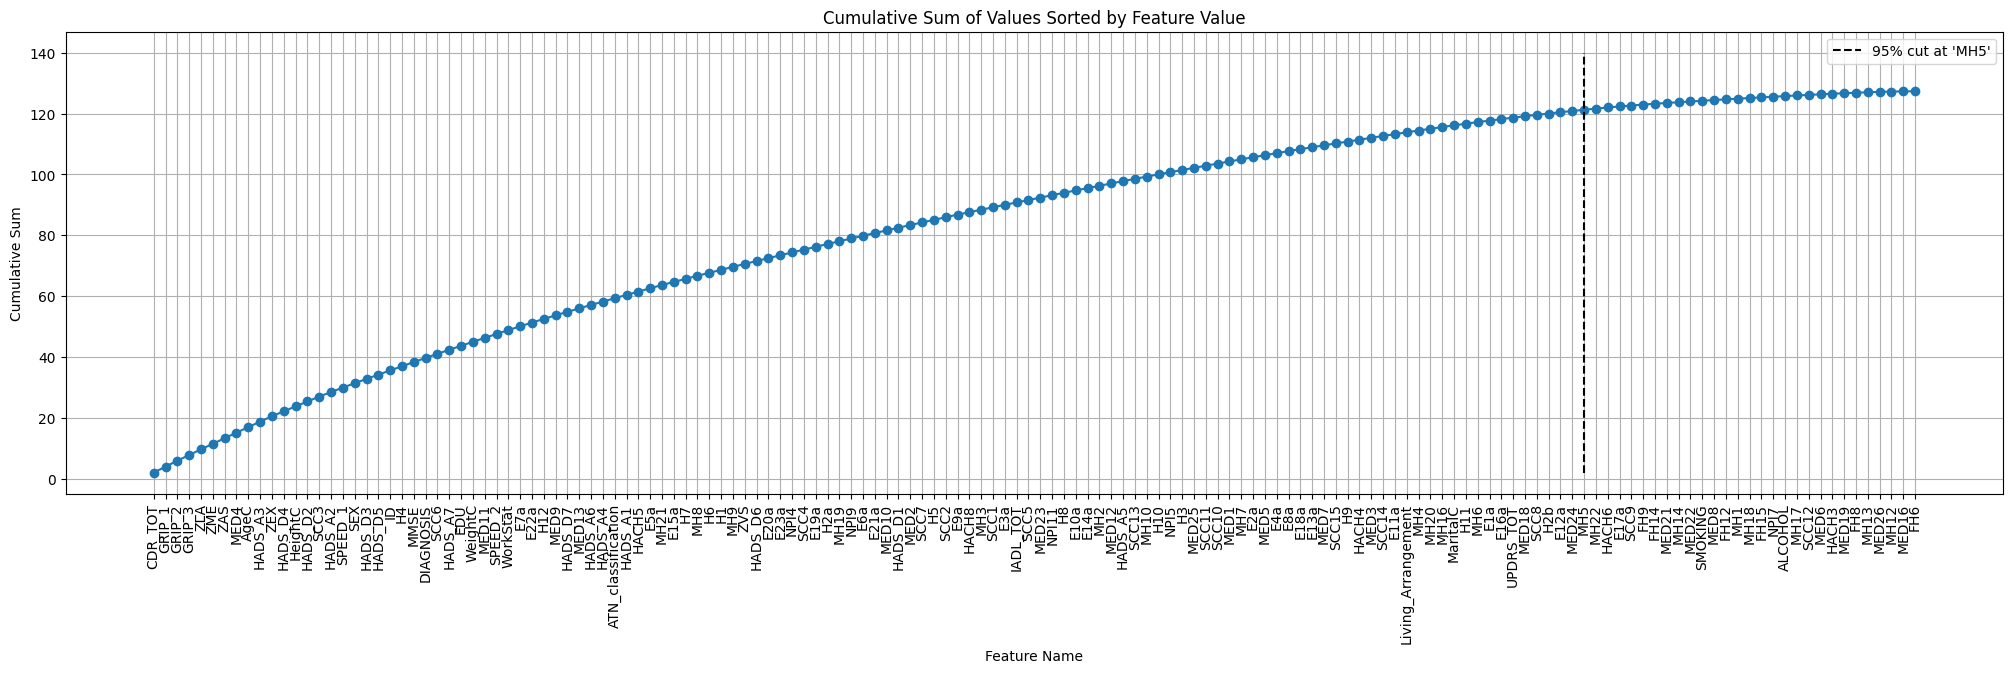

In [26]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df['feature_name'], sorted_df['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df['cumulative_sum'].min(),
    ymax=1.1 * sorted_df['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_visit1 = filtered_df['feature_name'].tolist()

df_visit1 = df_visit1.drop(columns=features_to_drop_visit1)

In [31]:
df_visit1 = df_visit1.drop(columns=["GRIP_2", "GRIP_3", "E1a", "E23a", "H7", "E8a", "MH2", "SCC4"]) # Manually selected from the next step, features that had correlation >0.85

corr_matrix = df_visit1.corr()

corr_unstacked = corr_matrix.unstack()

# Convert to a DataFrame and reset index
corr_df = pd.DataFrame(corr_unstacked, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable_1'] != corr_df['Variable_2']]

# Drop duplicate pairs
corr_df['pair'] = corr_df.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df = corr_df.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df = corr_df.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df = corr_df.sort_values(by='correlation', ascending=False)


In [32]:
corr_df[corr_df['correlation'] > 0.85] 

Empty DataFrame
Columns: [Variable_1, Variable_2, correlation]
Index: []

# Obtain features that should be removed based on visit 2

In [34]:
# Prepare the data of the second visit for the feature refinement steps
features_to_remove_visit2 = ["NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14",]

train_df_visit2_copy = train_df_visit2_copy.drop(columns=features_to_remove_visit2)
test_df_visit2_copy = test_df_visit2_copy.drop(columns=features_to_remove_visit2)
df_visit2 = pd.concat([train_df_visit2_copy, test_df_visit2_copy], axis=0)

In [36]:
# Fix data types
int_columns_visit2 = ["SEX", "EDU", "AgeC", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS_TOT", "DIAGNOSIS"
    ]

df_visit2[float_columns] = df_visit2[float_columns].astype('category')
df_visit2[int_columns_visit2] = df_visit2[int_columns_visit2].astype(int)

In [39]:
# Remove features with a constant value 
constant_columns_visit2 = [col for col in df_visit2.columns if df_visit2[col].nunique() == 1]

df_visit2 = df_visit2.drop(labels=constant_columns_visit2, axis=1)

In [40]:
X = df_visit2.values
feature_names = df_visit2.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        spearman_corr_matrix[i, j], _ = spearmanr(X[:, i], X[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix)

# Calculate the mutual information
mutual_info_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    mutual_info_matrix[i] = mutual_info_regression(X, X[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix)

# Compute the average absolute value of the correlations
avg_spearman_corr = np.mean(np.abs(spearman_corr_matrix), axis=0)
avg_mutual_info = np.mean(np.abs(mutual_info_matrix), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr)
print("\nAverage mutual information:")
print(avg_mutual_info)

# Combine the two averaged correlations
combined_corr = avg_spearman_corr + avg_mutual_info

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr)

# Scale the combined values between 0 and 1
scaler = MinMaxScaler()
scaled_combined_corr = scaler.fit_transform(combined_corr.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr)

# Sum the scaled values for each feature
final_values = scaled_combined_corr + scaled_combined_corr

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values)

# Create the resulting DataFrame
result_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': final_values
})

# Sort the DataFrame by the 'value' column
sorted_df = result_df.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df)

# Compute the cumulative sum of the 'value' column
sorted_df['cumulative_sum'] = sorted_df['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df = sorted_df[sorted_df['cumulative_sum'] > 0.95 * sorted_df['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 90% of total):")
print(filtered_df)

# If the filtered DataFrame is not empty, proceed
if not filtered_df.empty:
    limit_feature = filtered_df['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 90% threshold, take the last feature
    limit_feature = sorted_df['feature_name'].iloc[-1]

Spearman correlation matrix:
[[ 1.00000000e+00  8.99622831e-02  2.17224482e-01 ...  1.99281146e-01
   1.71932475e-01 -1.17619063e-01]
 [ 8.99622831e-02  1.00000000e+00  7.55370935e-04 ...  1.01907898e-02
   1.04376837e-02 -2.08376609e-01]
 [ 2.17224482e-01  7.55370935e-04  1.00000000e+00 ...  3.50224036e-01
   3.98765202e-01 -2.91882710e-01]
 ...
 [ 1.99281146e-01  1.01907898e-02  3.50224036e-01 ...  1.00000000e+00
   5.81374991e-01 -3.76226640e-01]
 [ 1.71932475e-01  1.04376837e-02  3.98765202e-01 ...  5.81374991e-01
   1.00000000e+00 -4.38228834e-01]
 [-1.17619063e-01 -2.08376609e-01 -2.91882710e-01 ... -3.76226640e-01
  -4.38228834e-01  1.00000000e+00]]

Mutual information matrix:
[[3.53278013 0.01111069 0.08519866 ... 0.01332801 0.         0.09589651]
 [0.01019242 0.63503741 0.         ... 0.01183067 0.         0.02414638]
 [0.10169714 0.         2.02773926 ... 0.12753404 0.16846136 0.0449362 ]
 ...
 [0.01036751 0.027735   0.09100723 ... 3.42264633 0.20246145 0.05382351]
 [0.      


Limit feature (where 95% cumulative sum is reached or fallback): MED3


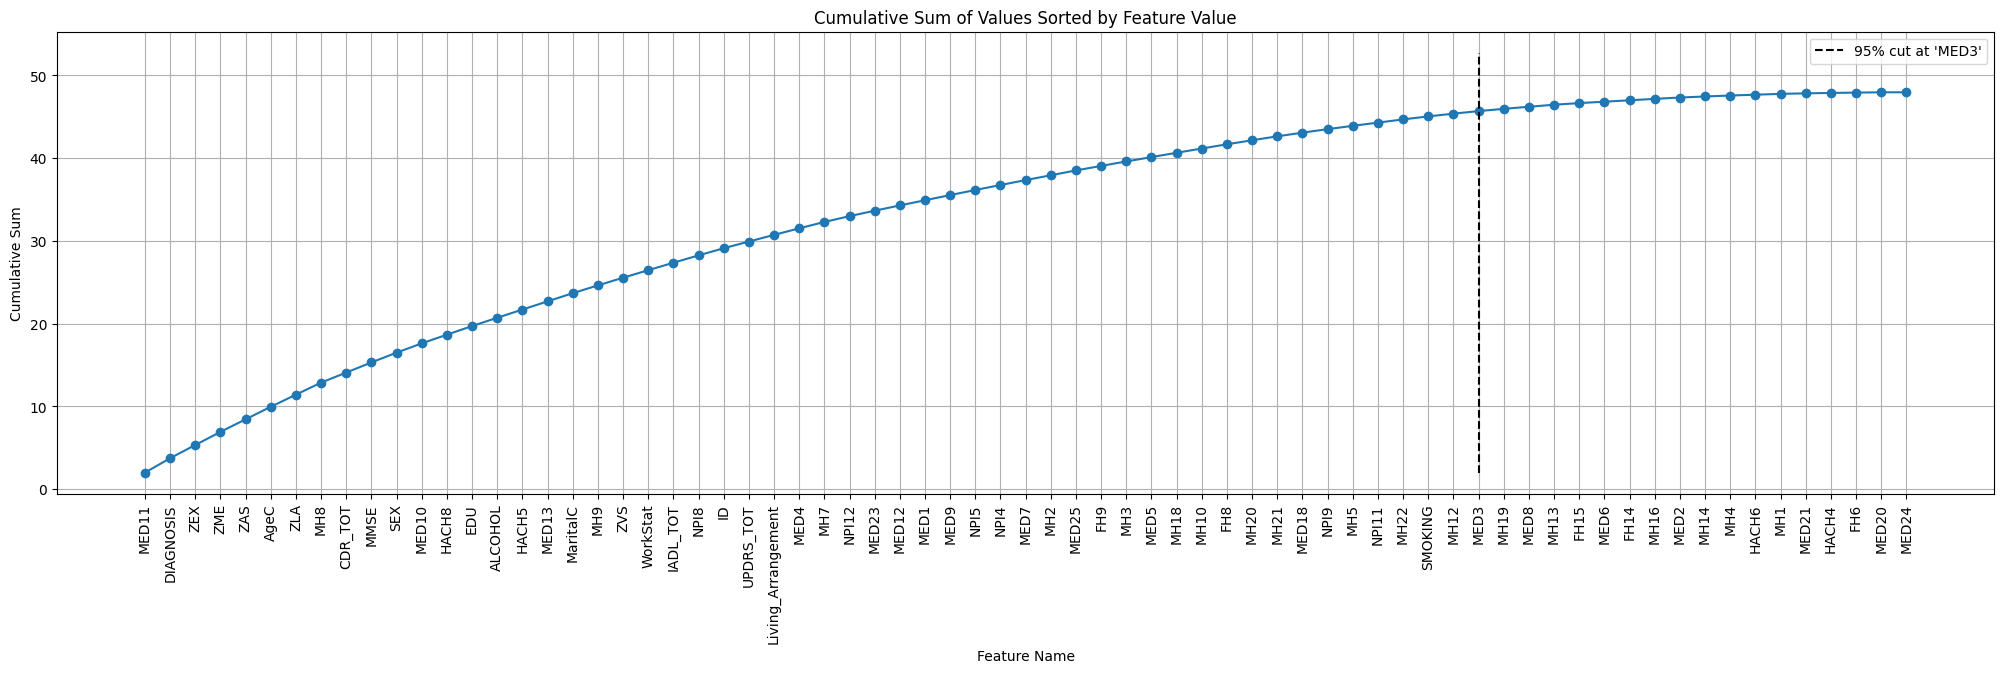

In [41]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df['feature_name'], sorted_df['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df['cumulative_sum'].min(),
    ymax=1.1 * sorted_df['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_visit2 = filtered_df['feature_name'].tolist()

df_visit2 = df_visit2.drop(columns=features_to_drop_visit2)

In [45]:
df_visit2 = df_visit2.drop(columns=["MH2", "MH8", "HACH5"]) # Manually selected from the next step, features that had correlation >0.85

corr_matrix = df_visit2.corr()

corr_unstacked = corr_matrix.unstack()

# Convert to a DataFrame and reset index
corr_df = pd.DataFrame(corr_unstacked, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable_1'] != corr_df['Variable_2']]

# Drop duplicate pairs
corr_df['pair'] = corr_df.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df = corr_df.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df = corr_df.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df = corr_df.sort_values(by='correlation', ascending=False)


In [46]:
corr_df[corr_df['correlation'] > 0.85] 

Empty DataFrame
Columns: [Variable_1, Variable_2, correlation]
Index: []

# Obtain features that should be removed based on visit 3

In [48]:
# Prepare the data of the third visit for the feature refinement steps
train_df_visit3_copy = train_df_visit3_copy.drop(columns=features_to_remove)
test_df_visit3_copy = test_df_visit3_copy.drop(columns=features_to_remove)
df_visit3 = pd.concat([train_df_visit3_copy, test_df_visit3_copy], axis=0)

In [49]:
float_columns = ["ΜaritalC", "Living_Arrangement", "WorkStat"]
df_visit3[float_columns] = df_visit3[float_columns].astype('category')


In [50]:
# Fix data types
df_visit3[float_columns] = df_visit3[float_columns].astype('category')
df_visit3[int_columns] = df_visit3[int_columns].astype(int)

In [53]:
# Remove features with a constant value 
constant_columns_visit3 = [col for col in df_visit3.columns if df_visit3[col].nunique() == 1]
df_visit3 = df_visit3.drop(labels=constant_columns_visit3, axis=1)

In [54]:
X = df_visit3.values
feature_names = df_visit3.columns

# Calculate the Spearman correlation matrix
spearman_corr_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        spearman_corr_matrix[i, j], _ = spearmanr(X[:, i], X[:, j])

# Print the Spearman correlation matrix
print("Spearman correlation matrix:")
print(spearman_corr_matrix)

# Calculate the mutual information
mutual_info_matrix = np.empty((X.shape[1], X.shape[1]))
for i in range(X.shape[1]):
    mutual_info_matrix[i] = mutual_info_regression(X, X[:, i], random_state=29)

# Print the mutual information matrix
print("\nMutual information matrix:")
print(mutual_info_matrix)

# Compute the average absolute value of the correlations
avg_spearman_corr = np.mean(np.abs(spearman_corr_matrix), axis=0)
avg_mutual_info = np.mean(np.abs(mutual_info_matrix), axis=0)

# Print average Spearman correlation and mutual information
print("\nAverage Spearman correlation:")
print(avg_spearman_corr)
print("\nAverage mutual information:")
print(avg_mutual_info)

# Combine the two averaged correlations
combined_corr = avg_spearman_corr + avg_mutual_info

# Print combined correlation
print("\nCombined correlation (Spearman + Mutual Info):")
print(combined_corr)

# Scale the combined values between 0 and 1
scaler = MinMaxScaler()
scaled_combined_corr = scaler.fit_transform(combined_corr.reshape(-1, 1)).flatten()

# Print scaled combined correlation
print("\nScaled combined correlation:")
print(scaled_combined_corr)

# Sum the scaled values for each feature
final_values = scaled_combined_corr + scaled_combined_corr

# Print final values for each feature
print("\nFinal values (scaled combined correlation + itself):")
print(final_values)

# Create the resulting DataFrame
result_df = pd.DataFrame({
    'feature_name': feature_names,
    'value': final_values
})

# Sort the DataFrame by the 'value' column
sorted_df = result_df.sort_values('value', ascending=False)

# Print the sorted DataFrame
print("\nSorted DataFrame:")
print(sorted_df)

# Compute the cumulative sum of the 'value' column
sorted_df['cumulative_sum'] = sorted_df['value'].cumsum()

# Print the DataFrame with cumulative sum
print("\nDataFrame with cumulative sum:")
print(sorted_df)

# Check if any rows meet the 95% cumulative sum threshold
filtered_df = sorted_df[sorted_df['cumulative_sum'] > 0.95 * sorted_df['cumulative_sum'].max()]

# Print the filtered DataFrame and check if it's empty
print("\nFiltered DataFrame (cumulative sum > 90% of total):")
print(filtered_df)

# If the filtered DataFrame is not empty, proceed
if not filtered_df.empty:
    limit_feature = filtered_df['feature_name'].iloc[0]
else:
    # Fallback option: if no feature meets the 90% threshold, take the last feature
    limit_feature = sorted_df['feature_name'].iloc[-1]



Spearman correlation matrix:
[[ 1.          0.0417682   0.19982186 ...  0.07207817  0.09234703
   0.05526764]
 [ 0.0417682   1.         -0.05570794 ... -0.60393699 -0.51783821
  -0.64555813]
 [ 0.19982186 -0.05570794  1.         ...  0.09904736  0.12194539
   0.08753006]
 ...
 [ 0.07207817 -0.60393699  0.09904736 ...  1.          0.40735239
   0.48647706]
 [ 0.09234703 -0.51783821  0.12194539 ...  0.40735239  1.
   0.66489639]
 [ 0.05526764 -0.64555813  0.08753006 ...  0.48647706  0.66489639
   1.        ]]

Mutual information matrix:
[[3.24282701e+00 4.81679753e-02 3.92857121e-02 ... 0.00000000e+00
  0.00000000e+00 2.61141219e-03]
 [4.81679753e-02 6.03406243e-01 0.00000000e+00 ... 2.38390390e-01
  1.50112978e-01 2.50276238e-01]
 [4.25203570e-02 0.00000000e+00 1.88531927e+00 ... 1.88151084e-02
  2.31973915e-02 0.00000000e+00]
 ...
 [0.00000000e+00 2.31692326e-01 3.96246441e-02 ... 3.20894423e+00
  1.10674391e-01 1.33401900e-01]
 [0.00000000e+00 1.50909588e-01 4.47705123e-02 ... 1.07926


Limit feature (where 95% cumulative sum is reached or fallback): E21a


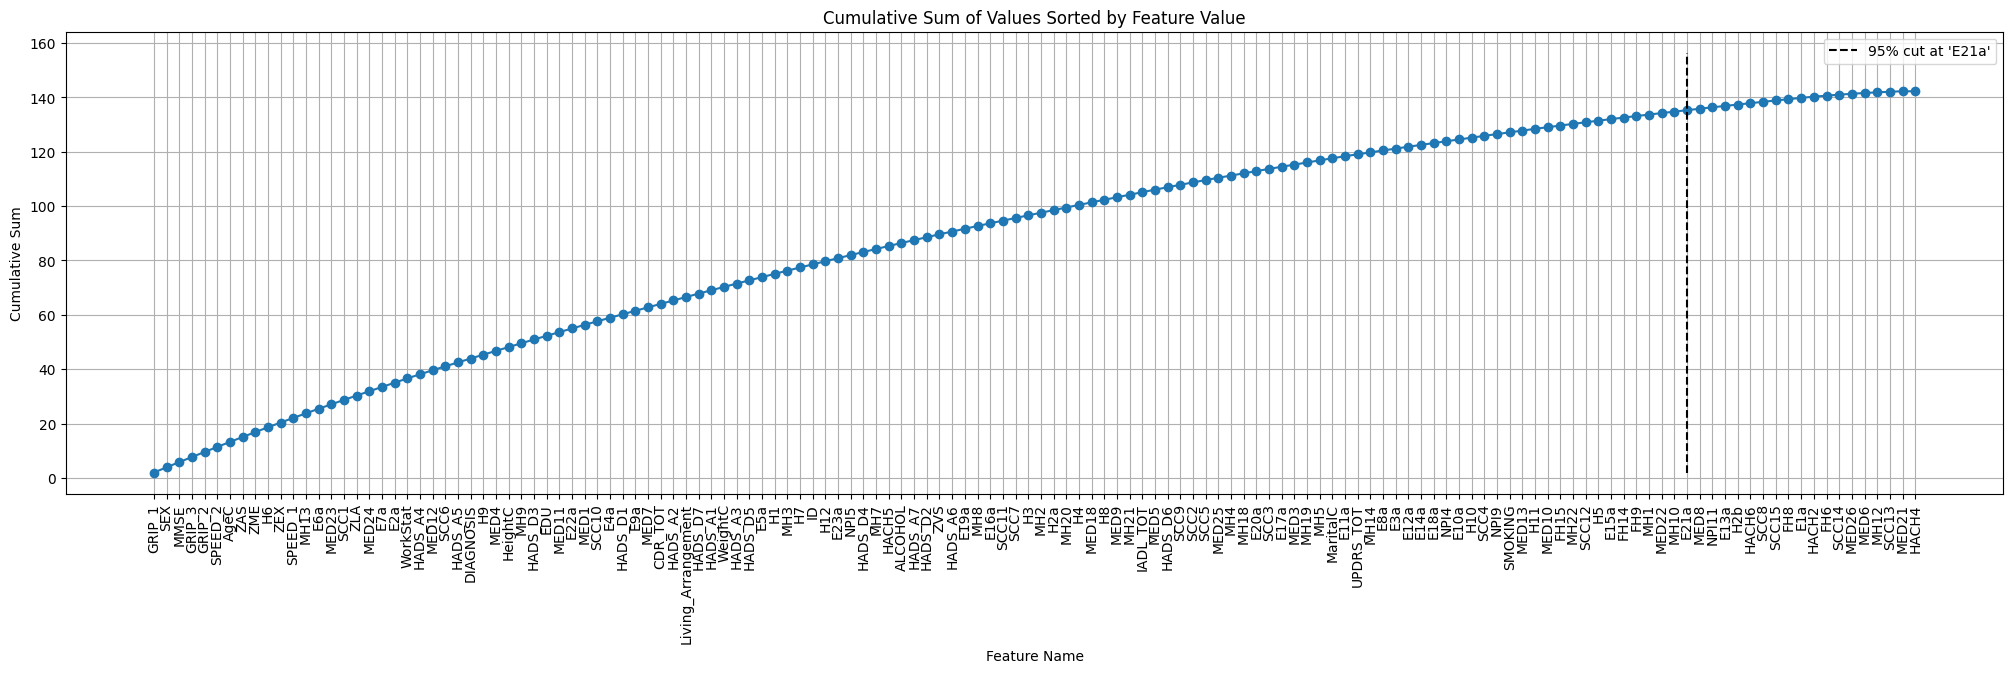

In [55]:
# Print the limit feature
print(f"\nLimit feature (where 95% cumulative sum is reached or fallback): {limit_feature}")

# Plotting
plt.figure(figsize=(25,6))
plt.plot(sorted_df['feature_name'], sorted_df['cumulative_sum'], marker='o')
plt.vlines(
    x=limit_feature,
    ymin=sorted_df['cumulative_sum'].min(),
    ymax=1.1 * sorted_df['cumulative_sum'].max(),
    label=f"95% cut at '{limit_feature}'",
    linestyles="dashed",
    color='black'
)
plt.xlabel('Feature Name')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values Sorted by Feature Value')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Remove unimportant features, in terms of mutual information and Spearman correlation
features_to_drop_visit3 = filtered_df['feature_name'].tolist()
df_visit3 = df_visit3.drop(columns=features_to_drop_visit3)

In [59]:
df_visit3 = df_visit3.drop(columns=["SCC2", "HADS_D1", "E14a", "E12a", "H4", "E6a", "H9", "E7a", 
                                    "E1a","H1", "H8", "E8a", "E11a", "E13a", "E9a", "H11", "H7", 
                                    "H12", "H6", "SCC4", "MED11", "GRIP_2", "GRIP_3", "H3", "SPEED_2"]) # Manually selected from the next step, features that had correlation >0.85

corr_matrix = df_visit3.corr()

corr_unstacked = corr_matrix.unstack()

# Convert to a DataFrame and reset index
corr_df = pd.DataFrame(corr_unstacked, columns=['correlation']).reset_index()

# Rename the columns for better understanding
corr_df.columns = ['Variable_1', 'Variable_2', 'correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable_1'] != corr_df['Variable_2']]

# Drop duplicate pairs
corr_df['pair'] = corr_df.apply(lambda row: tuple(sorted([row['Variable_1'], row['Variable_2']])), axis=1)
corr_df = corr_df.drop_duplicates(subset=['pair'])

# Drop the 'pair' column as it's no longer needed
corr_df = corr_df.drop(columns=['pair'])

# Sort by correlation value in descending order
corr_df = corr_df.sort_values(by='correlation', ascending=False)


In [ ]:
corr_df[corr_df['correlation'] > 0.85] 

# Final feature removal

In [65]:
# Earlier feature selection steps have identified the following features as highly correlated
correlated_features_visit1 = ["MH2", "MH8", "HACH5"] 
correlated_features_visit2 = ["GRIP_2", "GRIP_3", "E1a", "E23a", "H7", "E8a", "MH2", "SCC4"] 
correlated_features_visit3 = ["SCC2", "HADS_D1", "E14a", "E12a", "H4", "E6a", "H9", "E7a", "E1a","H1", "H8", "E8a", "E11a", "E13a", "E9a", "H11", "H7", "H12", "H6", "SCC4", "MED11", "GRIP_2", "GRIP_3", "H3", "SPEED_2"]

# Combine all features to drop
correlated_features_all = list(set(correlated_features_visit1 + correlated_features_visit2 + correlated_features_visit3))
unique_features_to_drop = list(set(features_to_drop_visit1 + features_to_drop_visit2 + features_to_drop_visit3 + constant_columns_visit1 + constant_columns_visit2 + constant_columns_visit3 + correlated_features_all))

# Exclude VisitNuA
unique_features_to_drop.remove("VisitNuA")

train_df = train_df.drop(labels=unique_features_to_drop, axis=1)
test_df = test_df.drop(labels=unique_features_to_drop, axis=1)

# Train and Test Split

In [67]:
# Function to append visit information to IDs
def append_visit_suffix(ids, visit_columns, df):
    # Identify the visit column with value 1
    visit_suffix = df[visit_columns].idxmax(axis=1).str.split('_').str[-1]
    # Handle cases where no visit column has a value of 1 
    visit_suffix[df[visit_columns].sum(axis=1) == 0] = '1'
    # Append the visit suffix to the ID
    return ids + '_visit' + visit_suffix

# Define visit columns (excluding VisitNuA_1)
visit_columns = ['VisitNuA_2', 'VisitNuA_3']

# Apply the function to train and test datasets
train_ids = append_visit_suffix(train_df['ID'].astype(str), visit_columns, train_df)
test_ids = append_visit_suffix(test_df['ID'].astype(str), visit_columns, test_df)

# Define features and target variable for model training (excluding 'ID')
X_train = train_df.drop(columns=['DIAGNOSIS', 'ID'])
y_train = train_df['DIAGNOSIS']

X_test = test_df.drop(columns=['DIAGNOSIS', 'ID'])
y_test = test_df['DIAGNOSIS']

# Logistic Regression

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Parameters: {'C': np.float64(37.455011884736244), 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.6678068410462776

Confusion Matrix:
[[64  0]
 [24  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84        64
           1       1.00      0.04      0.08        25

    accuracy                           0.73        89
   macro avg       0.86      0.52      0.46        89
weighted avg       0.80      0.73      0.63        89

Matthews Correlation Coefficient (MCC): 0.1706

Feature Importance:
               Feature   Coefficient
50                AgeC  1.107975e-02
39                E19a  7.200266e-03
48                E18a  4.810587e-03
69             WeightC  4.517084e-03
76               SCC13  3.072012e-03
37             SPEED_1  2.217231e-03
35             HADS_D2  1.374175e-03
66            WorkStat  1.221841e-03
27                E20a  8.185320e-04
36                 H2a  7.900974e

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


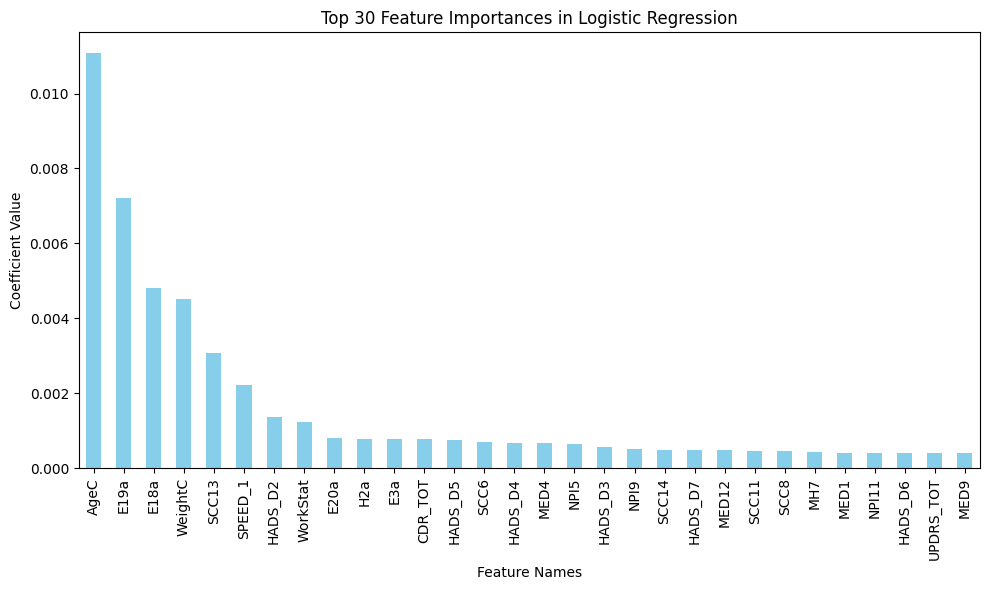

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

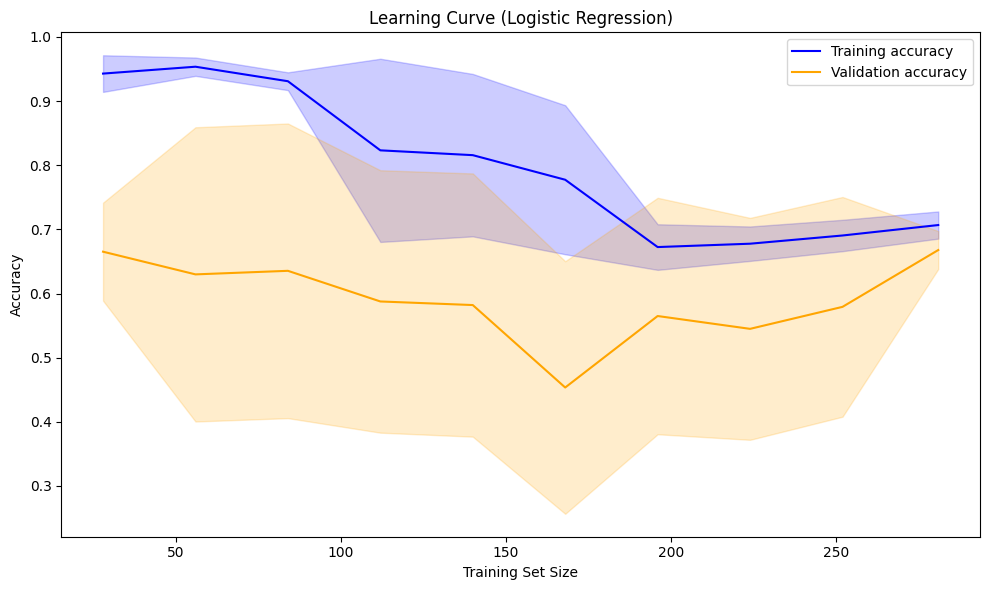

In [68]:
# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['saga'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train, y_train)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Logistic Regression + RFE

Selected features: ['Living_Arrangement', 'E4a', 'SCC14', 'HADS_A7', 'ZEX', 'MED25', 'MH21', 'HADS_A5', 'E5a', 'MH10', 'MED12', 'H5', 'MED7', 'HADS_D6', 'MED9', 'MED1', 'MED13', 'ZME', 'SEX', 'MH7', 'ZLA', 'SCC8', 'ZAS', 'ZVS', 'HADS_A6', 'CDR_TOT', 'MED5', 'SCC11', 'HADS_D4', 'HACH8']
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Parameters: {'C': np.float64(37.455011884736244), 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.693158953722334

Confusion Matrix:
[[64  0]
 [25  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        64
           1       0.00      0.00      0.00        25

    accuracy                           0.72        89
   macro avg       0.36      0.50      0.42        89
weighted avg       0.52      0.72      0.60        89

Matthews Correlation Coefficient (MCC): 0.0000

Feature Importance:
               Feature  Coefficient
21                SCC8     0.008322
2                SCC14     0.008294
27               SCC11     0.007535
7              HADS_A5     0.006125
13             HADS_D6     0.005377
3              HADS_A7     0.005203
28             HADS_D4     0.003730
24             HADS_A6     0.003278
25             CDR_TOT     0.002697
15                MED1     0.001549
19      

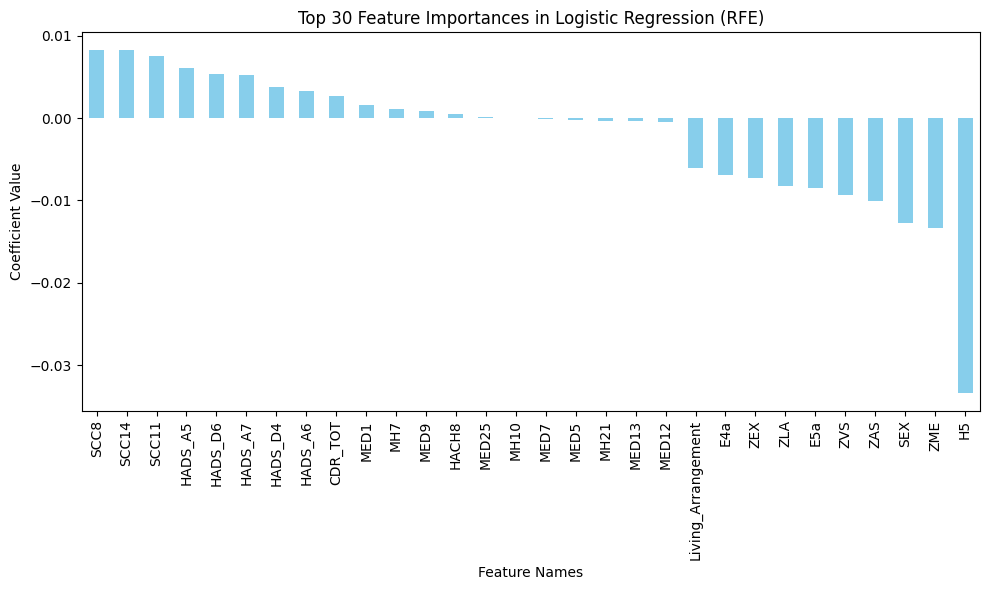

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

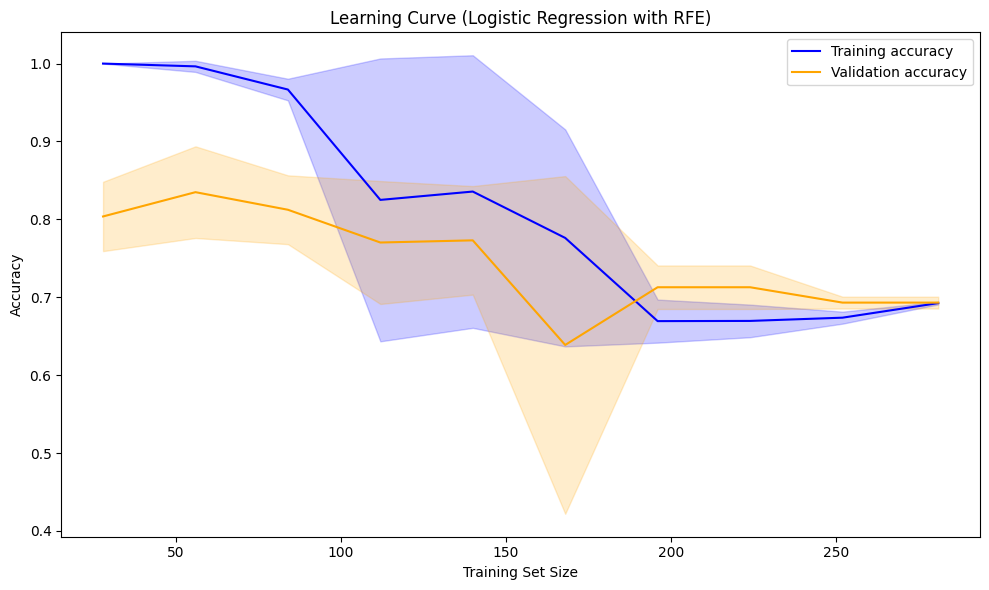

In [69]:
# Initialize logistic regression for RFE
logistic_rfe = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# Perform RFE
rfe = RFE(estimator=logistic_rfe, n_features_to_select=30)  # Adjust `n_features_to_select` as needed
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['saga'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_rfe, y_train)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_rfe)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (RFE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_rfe,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Logistic Regression + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    243
1    243
Name: count, dtype: int64
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Parameters: {'C': np.float64(37.455011884736244), 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.38857563644014304

Confusion Matrix:
[[38 26]
 [ 9 16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68        64
           1       0.38      0.64      0.48        25

    accuracy                           0.61        89
   macro avg       0.59      0.62      0.58        89
weighted avg       0.69      0.61      0.63        89

Matthews Correlation Coefficient (MCC): 0.2104

Feature Importance:
               Feature   Coefficient
50                AgeC  1.631827e-02
39                E19a  8.483792e-03
69             WeightC  7.482766e-03
48                E18a  5.760882e-03
76               SCC13  2.904198e-03
37             SPEED_1  2.842895e-03
41                 E3a  2.217162e-03
66            WorkStat  1.392398e-03
36                 H2a  1.213716e-03
35             HADS_D2  1.070759

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


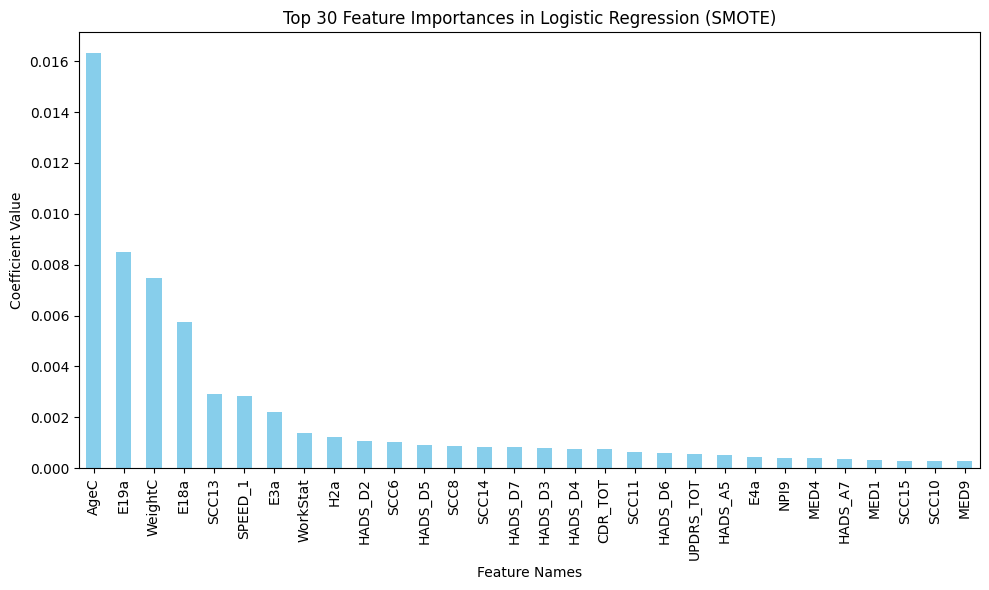

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

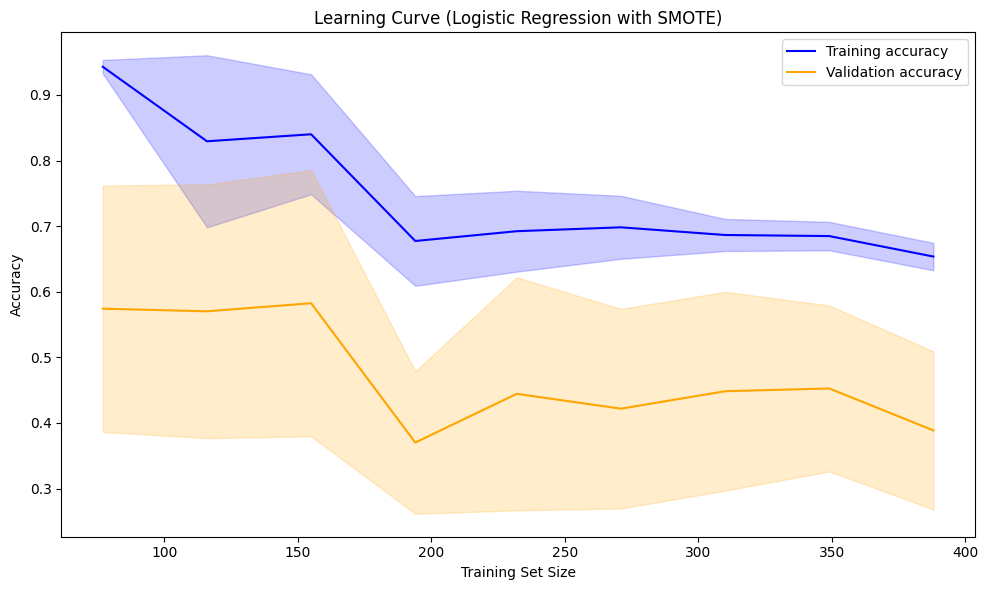

In [70]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Define a randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['saga'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_smote, y_train_smote)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (SMOTE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Logistic Regression + RFE + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    243
1    243
Name: count, dtype: int64


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Selected Features via RFE:
Index(['Living_Arrangement', 'E4a', 'MH3', 'SCC5', 'SCC14', 'MED18', 'HADS_A7',
       'ZEX', 'MH21', 'E5a', 'MH10', 'SPEED_1', 'H5', 'MED7', 'SCC7',
       'HADS_D6', 'MED9', 'MED1', 'UPDRS_TOT', 'ZME', 'SEX', 'ZLA', 'E10a',
       'SCC8', 'HADS_A6', 'ΜaritalC', 'CDR_TOT', 'MED5', 'SCC13', 'HADS_D4'],
      dtype='object')
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best Parameters: {'C': np.float64(37.455011884736244), 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.390279823269514

Confusion Matrix:
[[44 20]
 [ 5 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        64
           1       0.50      0.80      0.62        25

    accuracy                           0.72        89
   macro avg       0.70      0.74      0.70        89
weighted avg       0.79      0.72      0.73        89

Matthews Correlation Coefficient (MCC): 0.4405

Feature Importance:
               Feature  Coefficient
11             SPEED_1     0.012652
28               SCC13     0.006287
26             CDR_TOT     0.002690
29             HADS_D4     0.001928
18           UPDRS_TOT     0.001838
17                MED1     0.001155
23                SCC8     0.001122
4                SCC14     0.001114
1                  E4a     0.000802
16                MED9     0.000793
15      

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


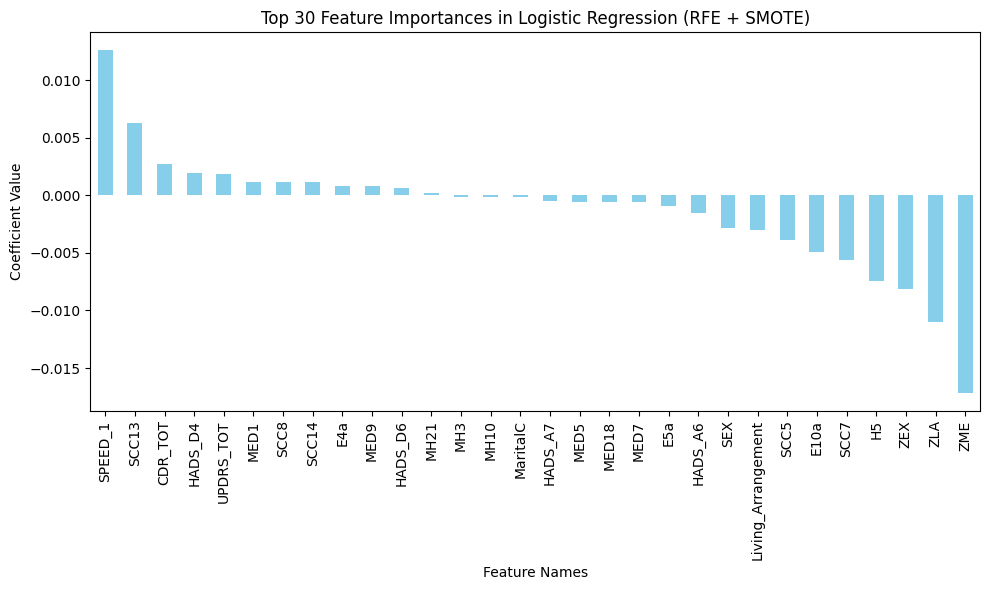

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

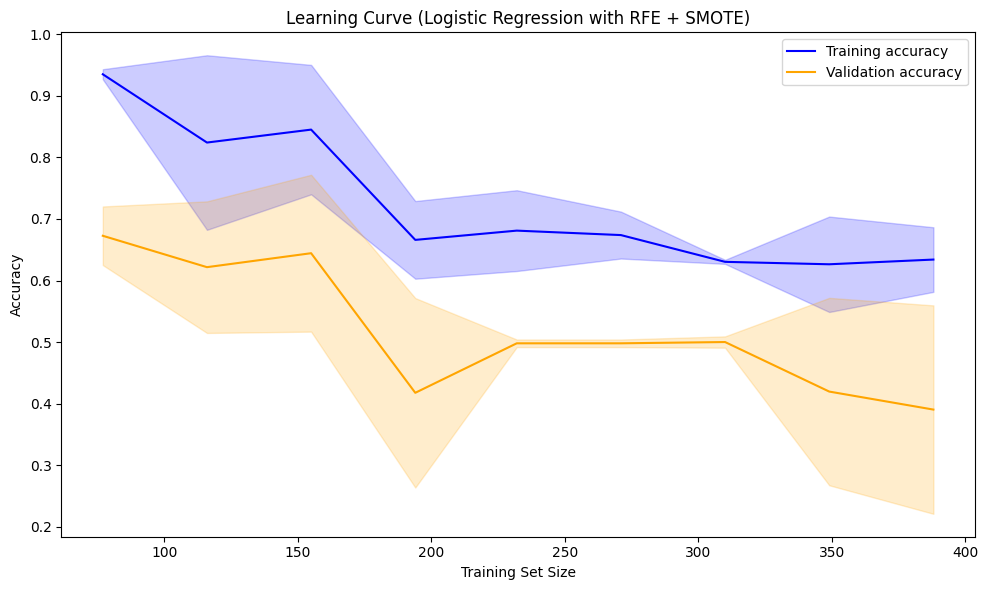

In [71]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Apply RFE 
rfe = RFE(estimator=logistic_model, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

# Print selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define a more extensive randomized hyperparameter grid
param_distributions = {
    'C': uniform(0.001, 100),  # Continuous range for regularization strength
    'penalty': ['l1', 'l2'],   # Regularization type
    'solver': ['saga'],   # Solvers compatible with l1 and l2
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=param_distributions,
    n_iter=50,                 # Number of parameter settings to sample
    scoring='accuracy',        # Use accuracy as the evaluation metric
    cv=5,                      # 5-fold cross-validation
    verbose=1,                 # Print progress
    random_state=42,           # Ensure reproducibility
    n_jobs=-1                  # Use all available processors
)

# Perform hyperparameter tuning
random_search.fit(X_train_rfe, y_train_smote)

# Print the best parameters and cross-validated accuracy
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

# Use the best model to make predictions
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_rfe)

# Evaluate the best model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importance[:30].set_index('Feature')['Coefficient'].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in Logistic Regression (RFE + SMOTE)')
plt.ylabel('Coefficient Value')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve for Logistic Regression
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_rfe,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    random_state=42
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Logistic Regression with RFE + SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Decision Tree

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=15, min_samples_split=33; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross-validation Accuracy: 0.8693181818181818
Cross-validation MCC: 0.6976439087986746
Cross-validation Confusion Matrix:
[[218  25]
 [ 21  88]]
Cross-validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       243
           1       0.78      0.81      0.79       109

    accuracy                           0.87       352
   macro avg       0.85      0.85      0.85       352
weighted avg       0.87      0.87      0.87       352

Test Set Accuracy: 0.8651685393258427
Test Set MCC: 0.6856325211240993
Test Set Confusion Matrix:
[[56  8]
 [ 4 21]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        64
           1       0.72      0.84      0.78        25

    accuracy                           0.87        89
   macro avg       0.83      0.86      0.84        89
weighted avg       0.87      0.87      0.87        89

Class 0: 0.8

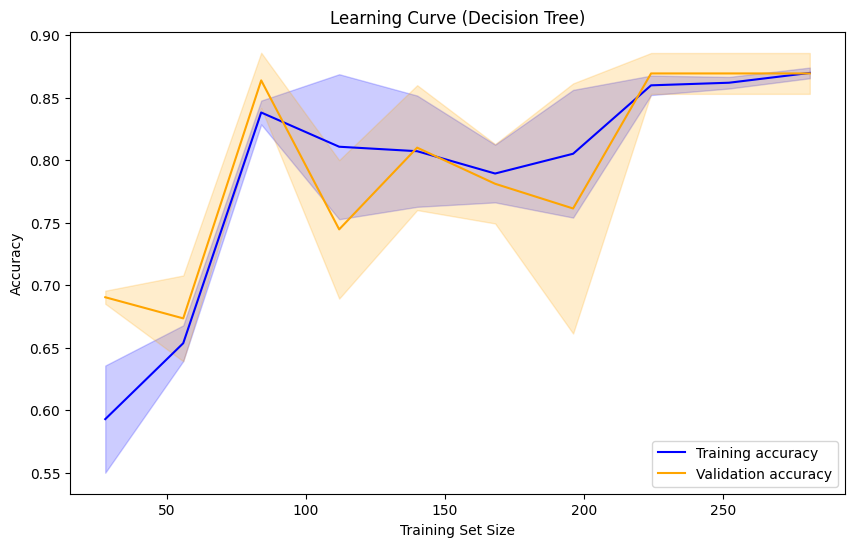

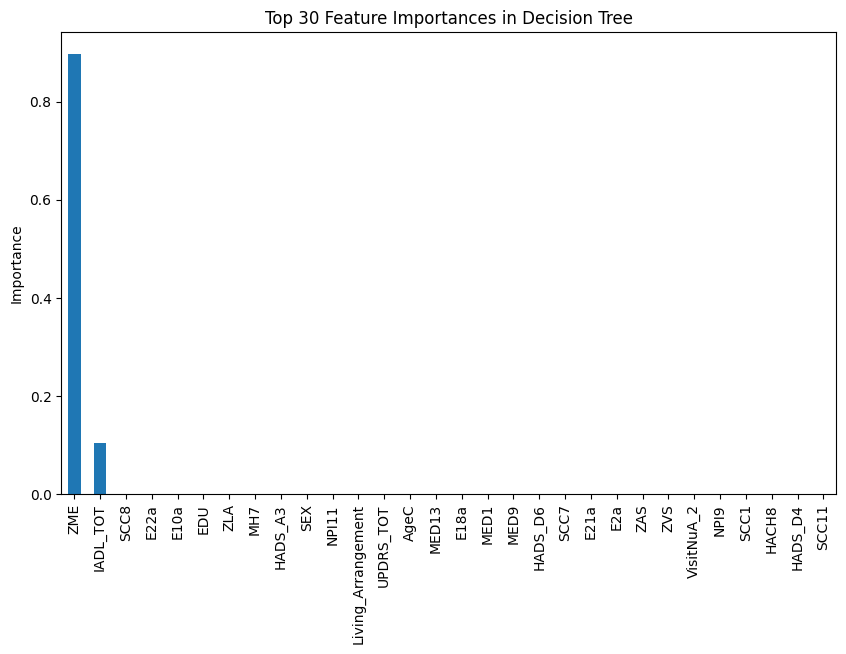

In [72]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train, y_train)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data
best_dt.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree')
plt.ylabel('Importance')
plt.show()

# Decision Tree + RFE

Selected Features via RFE:
Index(['Living_Arrangement', 'H10', 'MED4', 'E4a', 'H2b', 'MED23', 'HADS_D5',
       'HeightC', 'SCC5', 'SCC14', 'E5a', 'E20a', 'MH10', 'MMSE', 'SPEED_1',
       'NPI4', 'MED1', 'MED13', 'AgeC', 'UPDRS_TOT', 'ZME', 'MH7', 'ZLA',
       'EDU', 'E21a', 'ZAS', 'SCC15', 'WeightC', 'MH20', 'HADS_D4'],
      dtype='object')
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=15, min_impurity_decrease=0.2, min_samples_leaf=91, min_samples_split=70; total time=   0.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=15, min_impurity_decrease=0.2, min_samples_leaf=91, min_samples_split=70; total time=   0.0s
[CV] END ccp_alpha=0.2, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=15, min_impurity_decrease=0.2, min_samples_leaf=91, min_samples_split=70; total time=   0.0s
[CV] END ccp_alpha=0.2, criterion=entrop

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


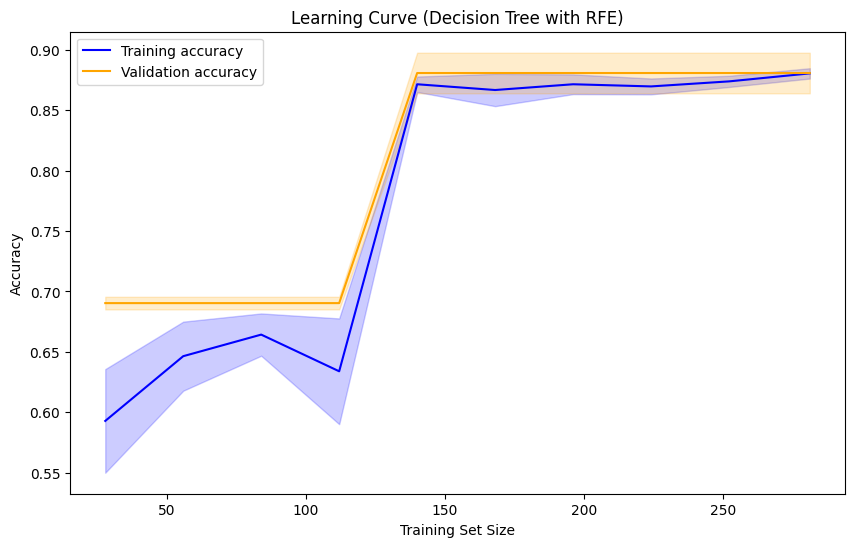

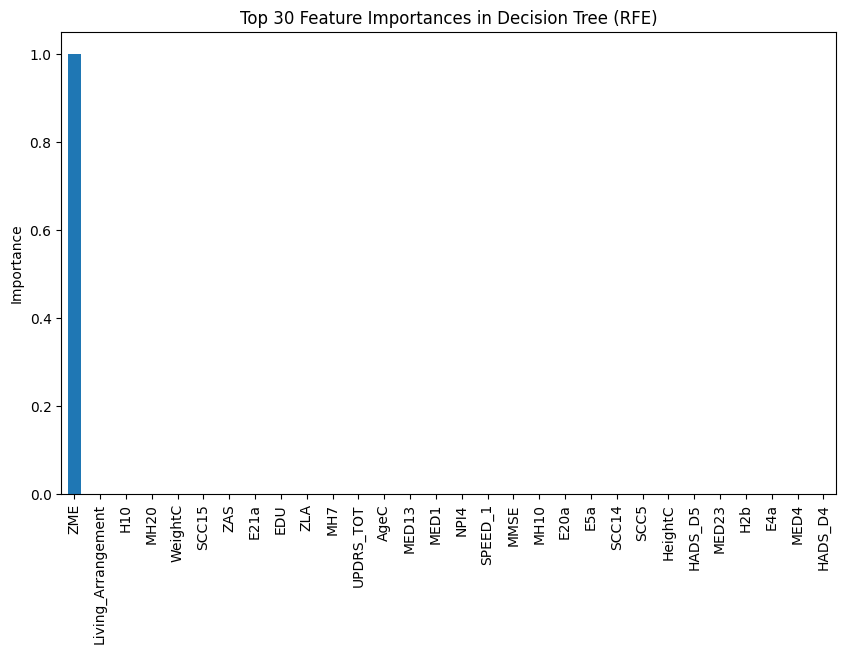

In [91]:
# Initialize the base Decision Tree model for RFE
base_dt = DecisionTreeClassifier(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_dt, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Keep standard criteria
    'max_depth': [3, 5, 7],                           # Further restrict depth
    'min_samples_split': randint(20, 100),            # Require more samples to split
    'min_samples_leaf': randint(10, 50),              # Increase minimum samples per leaf
    'max_features': ['sqrt', 'log2'],                 # Limit features considered for splits
    'max_leaf_nodes': [10, 20, 30],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.02, 0.05],      # Restrict splits with small impurity decreases
    'ccp_alpha': [0.01, 0.05, 0.1, 0.2]               # Add cost-complexity pruning to regularize
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_rfe, y_train)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_rfe, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_rfe, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data (with RFE-selected features)
best_dt.fit(X_train_rfe, y_train)

# Make predictions on the test set (with RFE-selected features)
y_pred = best_dt.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_rfe, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feat_importances = pd.Series(feature_importances, index=selected_features)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree (RFE)')
plt.ylabel('Importance')
plt.show()


# Decision Tree + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    243
1    243
Name: count, dtype: int64
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=50, min_impurity_decrease=0.1, min_samples_leaf=12, min_samples_split=30; total time=   0.0s
[CV] END criterion=g

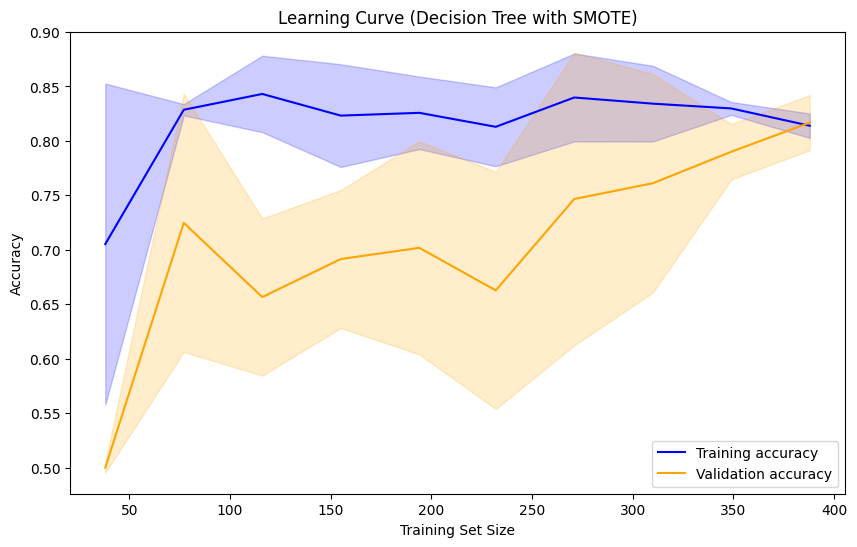

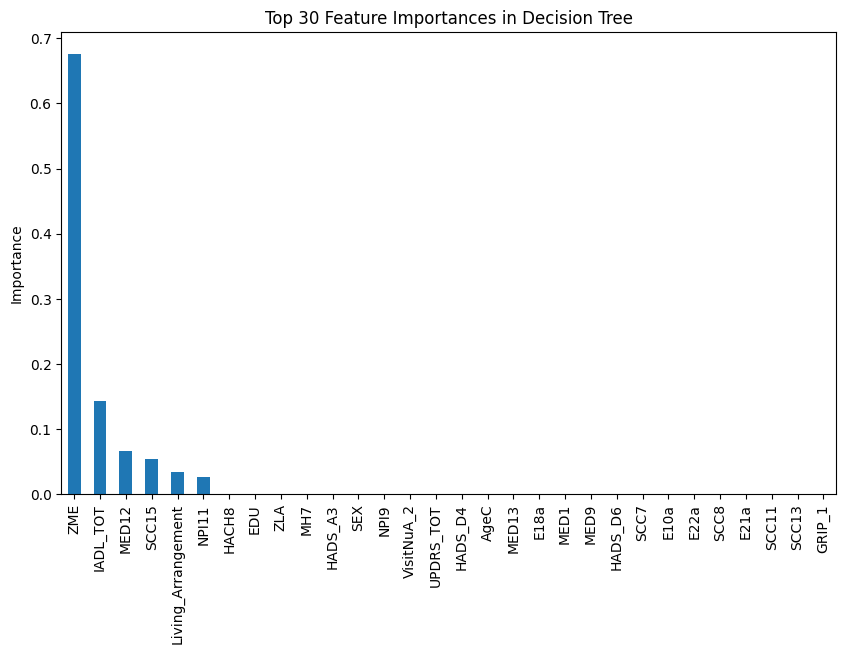

In [74]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Define a parameter grid for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Standard splitting criteria
    'max_depth': [3, 5, 7, 10],                       # Further reduce maximum depth
    'min_samples_split': randint(10, 50),             # Increase the minimum samples to split
    'min_samples_leaf': randint(5, 20),               # Increase the minimum samples in a leaf
    'max_features': ['sqrt', 'log2'],                 # Force splits to consider fewer features
    'max_leaf_nodes': [10, 20, 50],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.05, 0.1]        # Increase minimum impurity decrease
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_smote, y_train_smote, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_smote, y_train_smote, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_smote, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_smote, y_cv_pred)
cv_class_report = classification_report(y_train_smote, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_smote, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the full training data (after SMOTE)
best_dt.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = best_dt.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_smote, y_train_smote, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree')
plt.ylabel('Importance')
plt.show()


# Decision Tree + RFE + SMOTE

Class distribution after SMOTE:
DIAGNOSIS
0    243
1    243
Name: count, dtype: int64
Selected Features via RFE:
Index(['Living_Arrangement', 'H10', 'E4a', 'H2b', 'MED23', 'HADS_D5', 'MH3',
       'HeightC', 'SCC5', 'MED18', 'HADS_A7', 'ZEX', 'MH21', 'E5a', 'E20a',
       'MH10', 'MED12', 'MMSE', 'E15a', 'MED7', 'E3a', 'AgeC', 'ZME', 'SEX',
       'MH7', 'ZLA', 'EDU', 'WorkStat', 'WeightC', 'ΜaritalC'],
      dtype='object')
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.01, min_samples_leaf=30, min_samples_split=94; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.01, min_samples_leaf=30, min_samples_split=94; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=3, max_features=sqrt, max_leaf_nodes=30, min_impurity_decrease=0.01, min_samples_leaf=

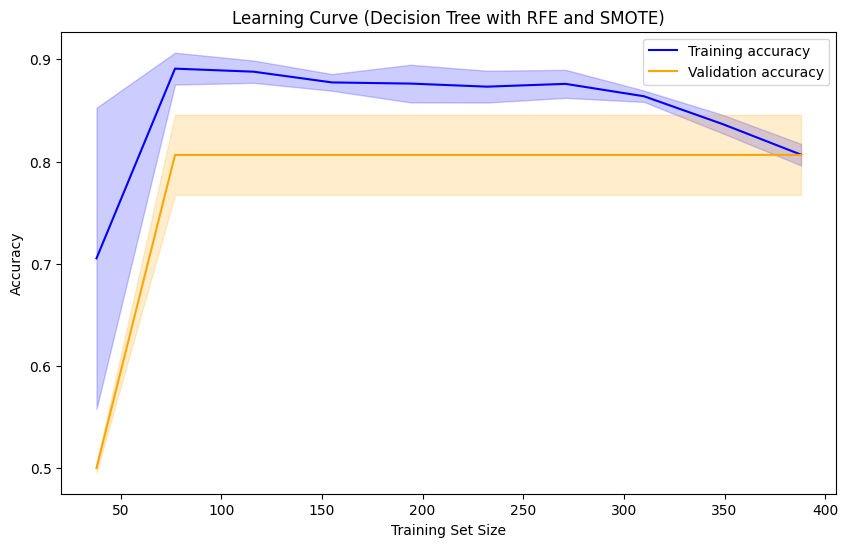

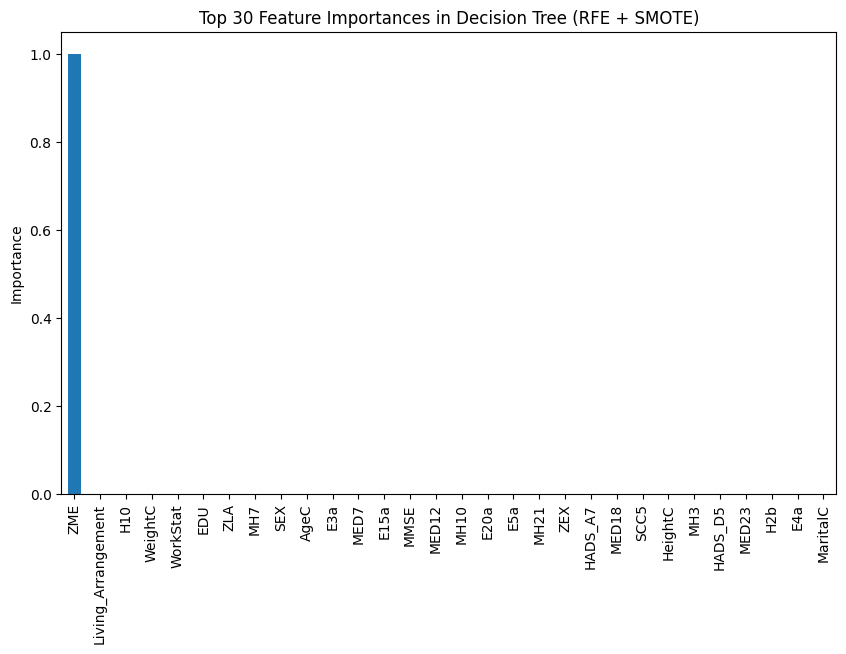

In [92]:
# Apply SMOTE 
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

# Initialize the base Decision Tree model for RFE
base_dt = DecisionTreeClassifier(random_state=42)

# Apply RFE
rfe = RFE(estimator=base_dt, n_features_to_select=30)  # Adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train_smote, y_train_smote)
X_test_rfe = rfe.transform(X_test)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features via RFE:")
print(selected_features)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],                  # Keep standard criteria
    'max_depth': [3, 5, 7],                           # Further restrict depth
    'min_samples_split': randint(20, 100),            # Require more samples to split
    'min_samples_leaf': randint(10, 50),              # Increase minimum samples per leaf
    'max_features': ['sqrt', 'log2'],                 # Limit features considered for splits
    'max_leaf_nodes': [10, 20, 30],                   # Strongly limit the number of leaf nodes
    'min_impurity_decrease': [0.01, 0.02, 0.05],      # Restrict splits with small impurity decreases
    'ccp_alpha': [0.01, 0.05, 0.1, 0.2]               # Add cost-complexity pruning to regularize
}

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize RandomizedSearchCV
dt_random = RandomizedSearchCV(estimator=dt, param_distributions=param_grid,
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
dt_random.fit(X_train_rfe, y_train_smote)

# Get the best estimator
best_dt = dt_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_dt, X_train_rfe, y_train_smote, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_dt, X_train_rfe, y_train_smote, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_smote, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_smote, y_cv_pred)
cv_class_report = classification_report(y_train_smote, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_smote, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print(f"Cross-validation MCC: {cv_mcc}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)

# Train the best model on the full training data (with RFE-selected features after SMOTE)
best_dt.fit(X_train_rfe, y_train_smote)

# Make predictions on the test set (with RFE-selected features)
y_pred = best_dt.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
test_mcc = matthews_corrcoef(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy}")
print(f"Test Set MCC: {test_mcc}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

for label, acc in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {acc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_dt, X_train_rfe, y_train_smote, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Decision Tree with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_dt.feature_importances_
feat_importances = pd.Series(feature_importances, index=selected_features)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Decision Tree (RFE + SMOTE)')
plt.ylabel('Importance')
plt.show()


# Random Forest

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=200;

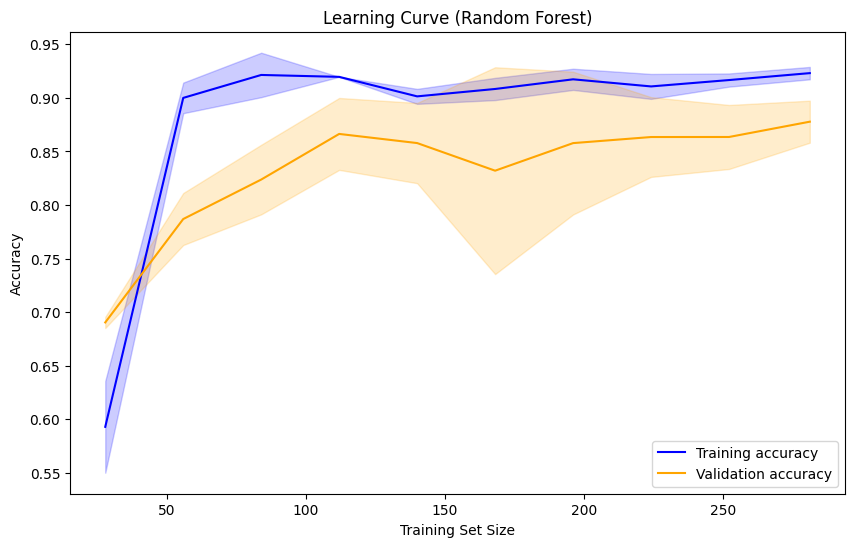

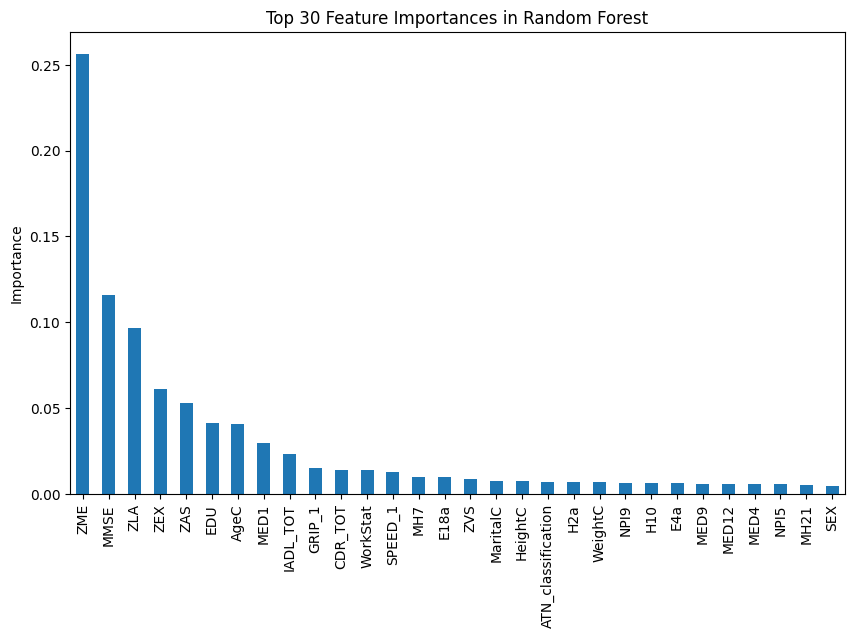

In [76]:
# Define a parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model
rf_random.fit(X_train, y_train)

# Get the best estimator
best_rf = rf_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_rf, X_train, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the full training data
best_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# Random Forest + RFE

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=200;

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross-validation scores: [0.88732394 0.87323944 0.91428571 0.88571429 0.91428571]
Mean cross-validation score: 0.8949698189134809
Cross-validation Accuracy: 0.8948863636363636
Cross-validation Confusion Matrix:
[[227  16]
 [ 21  88]]
Cross-validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       243
           1       0.85      0.81      0.83       109

    accuracy                           0.89       352
   macro avg       0.88      0.87      0.88       352
weighted avg       0.89      0.89      0.89       352

Cross-validation MCC: 0.7514197187324957
Test Set Accuracy: 0.8651685393258427
Test Set Confusion Matrix:
[[55  9]
 [ 3 22]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        64
           1       0.71      0.88      0.79        25

    accuracy                           0.87        89
   macro avg       0.83 

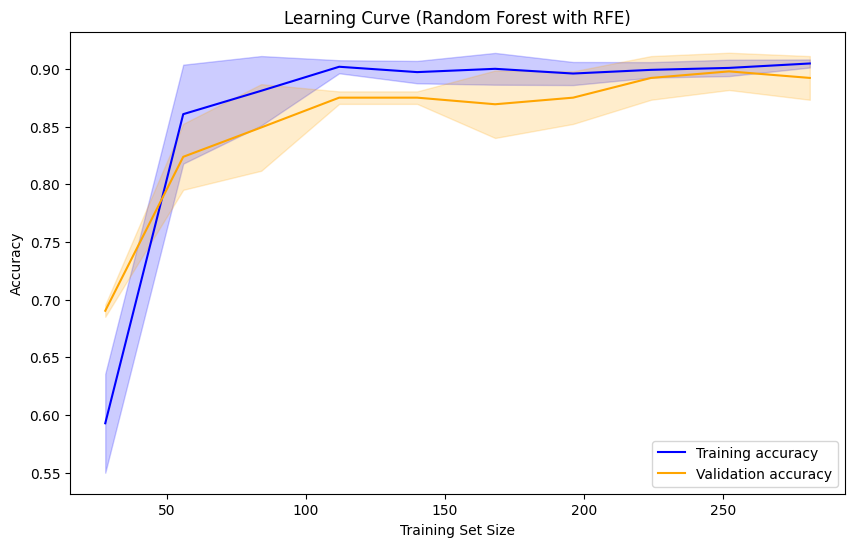

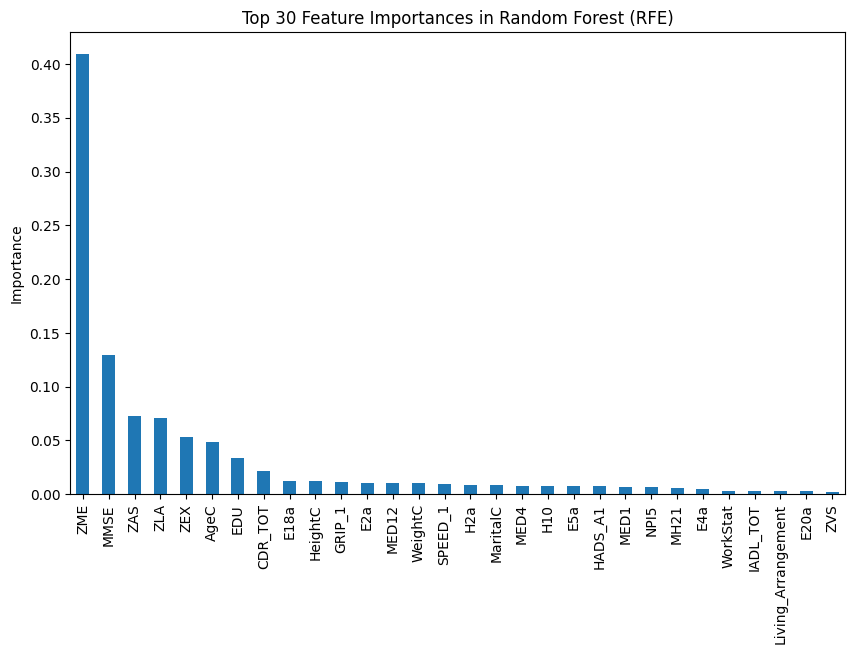

In [77]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Apply RFE
rfe = RFE(estimator=rf, n_features_to_select=30)  # You can adjust the number of features to select
rfe.fit(X_train, y_train)

# Transform the training and test sets with selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Initialize RandomizedSearchCV with the selected features
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                               n_iter=200, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search model on the reduced feature set
rf_random.fit(X_train_rfe, y_train)

# Get the best estimator
best_rf = rf_random.best_estimator_

# Perform cross-validation with the best estimator
cv_scores = cross_val_score(best_rf, X_train_rfe, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions
y_cv_pred = cross_val_predict(best_rf, X_train_rfe, y_train, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train, y_cv_pred)
cv_class_report = classification_report(y_train, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the full training data with reduced features
best_rf.fit(X_train_rfe, y_train)

# Make predictions on the test set with reduced features
y_pred = best_rf.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting with reduced features
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_rfe, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis for the selected features
selected_features = [f for f, s in zip(X_train.columns, rfe.support_) if s]
feature_importances = pd.Series(best_rf.feature_importances_, index=selected_features)
feature_importances = feature_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feature_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest (RFE)')
plt.ylabel('Importance')
plt.show()


# Random Forest + SMOTE

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=200; 

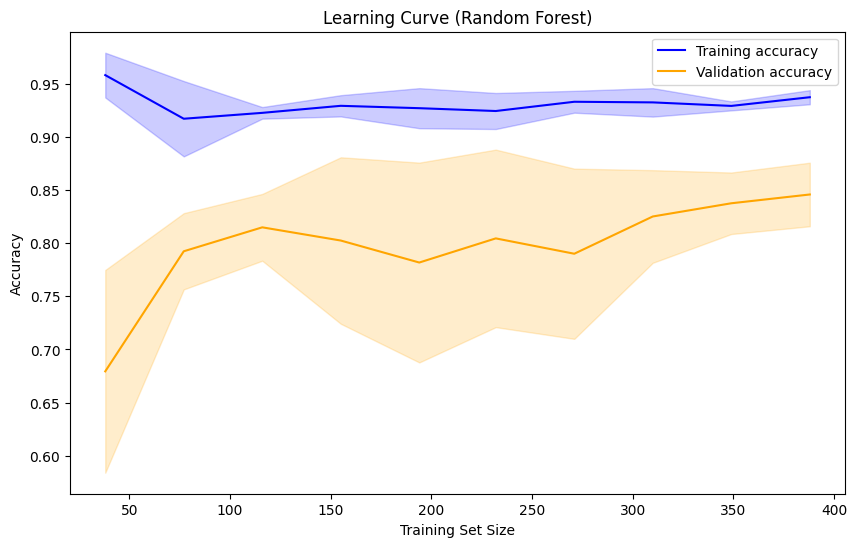

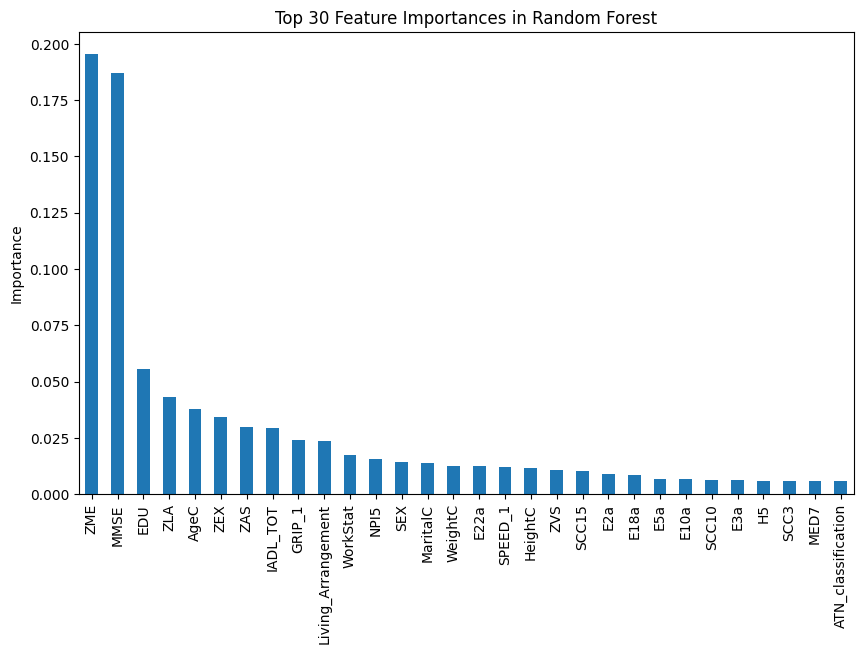

In [78]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the resampled training data
random_search.fit(X_train_res, y_train_res)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print(f"Best Parameters from Randomized Search: {best_params}")

# Train the best model on the resampled training data
best_rf = random_search.best_estimator_

# Perform cross-validation on the resampled training data with the best model
cv_scores = cross_val_score(best_rf, X_train_res, y_train_res, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions on the resampled training data
y_cv_pred = cross_val_predict(best_rf, X_train_res, y_train_res, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_res, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_res, y_cv_pred)
cv_class_report = classification_report(y_train_res, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_res, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the resampled training data
best_rf.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print("Class-Specific Accuracy:")
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Plot learning curves to check for overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_res, y_train_res, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# Random Forest + RFE + SMOTE

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, class_weight=None, max_depth=15, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=200; 

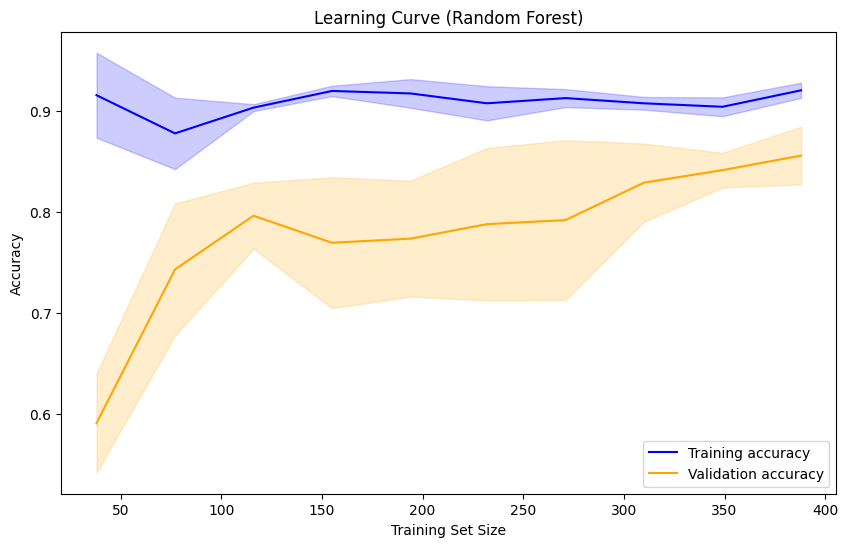

Test Set Accuracy: 0.797752808988764
Test Set Confusion Matrix:
[[48 16]
 [ 2 23]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84        64
           1       0.59      0.92      0.72        25

    accuracy                           0.80        89
   macro avg       0.77      0.83      0.78        89
weighted avg       0.86      0.80      0.81        89

Class-Specific Accuracy:
Class 0: 0.75
Class 1: 0.92
Test Set MCC: 0.6069004903015034


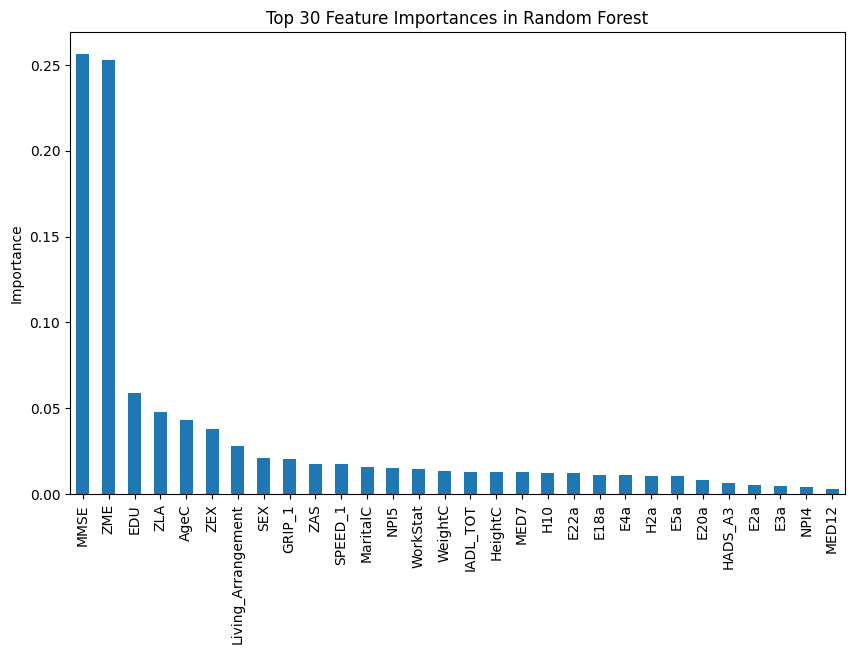

In [79]:
# Apply SMOTE 
smote = SMOTE(random_state=42) 
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=0)

# Apply RFE
rfe = RFE(estimator=rf, n_features_to_select=30)  # Adjust n_features_to_select as needed
X_train_res_rfe = rfe.fit_transform(X_train_res, y_train_res)
X_test_rfe = rfe.transform(X_test)  # Apply the same feature selection to the test data

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_split': [10, 15, 20, 30],
    'min_samples_leaf': [4, 6, 8, 10, 15],
    'bootstrap': [True],
    'class_weight': [None, 'balanced'],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV to the resampled and RFE-transformed training data
random_search.fit(X_train_res_rfe, y_train_res)

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print(f"Best Parameters from Randomized Search: {best_params}")

# Train the best model on the resampled and RFE-transformed training data
best_rf = random_search.best_estimator_

# Perform cross-validation on the resampled training data with the best model
cv_scores = cross_val_score(best_rf, X_train_res_rfe, y_train_res, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# Cross-validation predictions on the resampled and RFE-transformed training data
y_cv_pred = cross_val_predict(best_rf, X_train_res_rfe, y_train_res, cv=5)

# Evaluate cross-validation predictions
cv_accuracy = accuracy_score(y_train_res, y_cv_pred)
cv_conf_matrix = confusion_matrix(y_train_res, y_cv_pred)
cv_class_report = classification_report(y_train_res, y_cv_pred)
cv_mcc = matthews_corrcoef(y_train_res, y_cv_pred)

print(f"Cross-validation Accuracy: {cv_accuracy}")
print("Cross-validation Confusion Matrix:")
print(cv_conf_matrix)
print("Cross-validation Classification Report:")
print(cv_class_report)
print(f"Cross-validation MCC: {cv_mcc}")

# Train the best model on the resampled and RFE-transformed training data
best_rf.fit(X_train_res_rfe, y_train_res)

# Plot learning curves to assess potential overfitting
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_res_rfe, y_train_res, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Make predictions on the RFE-transformed test set
y_pred = best_rf.predict(X_test_rfe)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate class-specific accuracy
class_specific_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_labels = np.unique(y_test)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print("Class-Specific Accuracy:")
for label, accuracy in zip(class_labels, class_specific_accuracy):
    print(f"Class {label}: {accuracy}")
print(f"Test Set MCC: {mcc}")

# Feature importance analysis
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns[rfe.get_support()]  # Only include selected features
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
feat_importances[:30].plot(kind='bar')
plt.title('Top 30 Feature Importances in Random Forest')
plt.ylabel('Importance')
plt.show()


# LightGBM

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                   
[18]	cv_agg's valid binary_logloss: 0.349282 + 0.0465064
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                                             
[47]	cv_agg's valid binary_logloss: 0.356379 + 0.036099
Training until validation scores don't improve for 10 rounds                   
Early stopping, best iteration is:                                             
[36]	cv_agg's valid binary_logloss: 0.346962 + 0.0443309
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[100]	cv_agg's valid binary_logloss: 0.375548 + 0.0363595
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[63]	cv_agg's valid binary_logloss: 

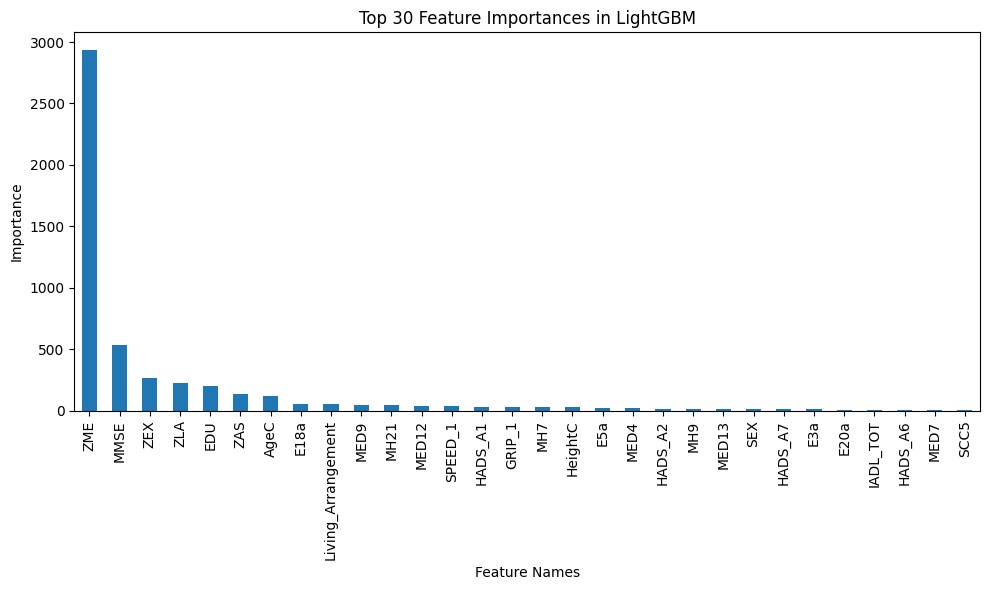

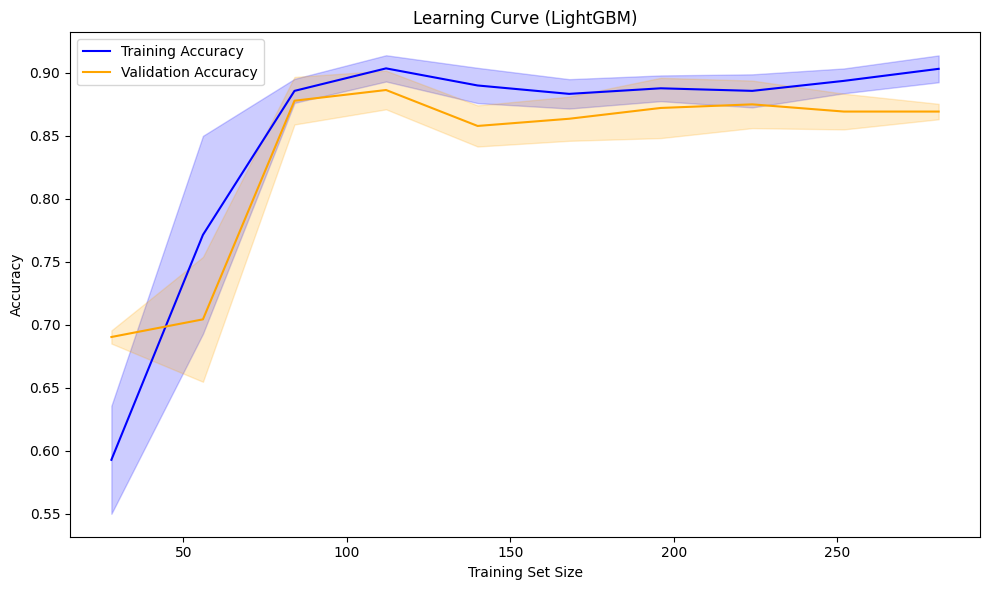

In [80]:
# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train = lgb.Dataset(X_train, label=y_train)
d_valid = lgb.Dataset(X_test, label=y_test, reference=d_train)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train,
    num_boost_round=100,
    valid_sets=[d_train, d_valid],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob = lgbm_model.predict(X_test)
lgbm_y_pred = (lgbm_y_pred_prob > 0.5).astype(int)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, lgbm_y_pred)
conf_matrix = confusion_matrix(y_test, lgbm_y_pred)
class_report = classification_report(y_test, lgbm_y_pred)
mcc = matthews_corrcoef(y_test, lgbm_y_pred)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use original feature names
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train,                            # Use original training data
    y_train,                            # Use original labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + RFE

[LightGBM] [Info] Number of positive: 109, number of negative: 243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 352, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.309659 -> initscore=-0.801714
[LightGBM] [Info] Start training from score -0.801714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

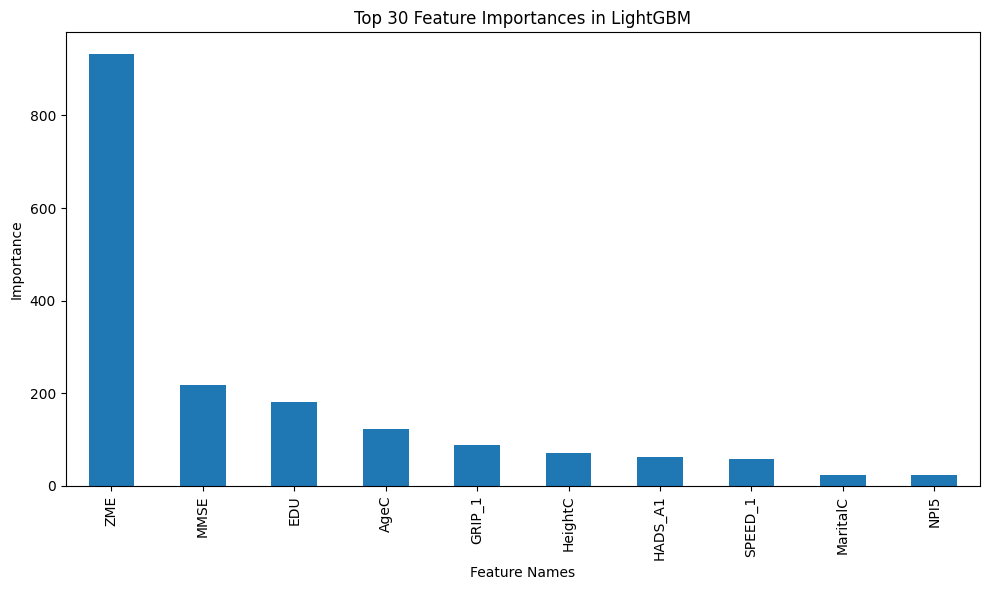

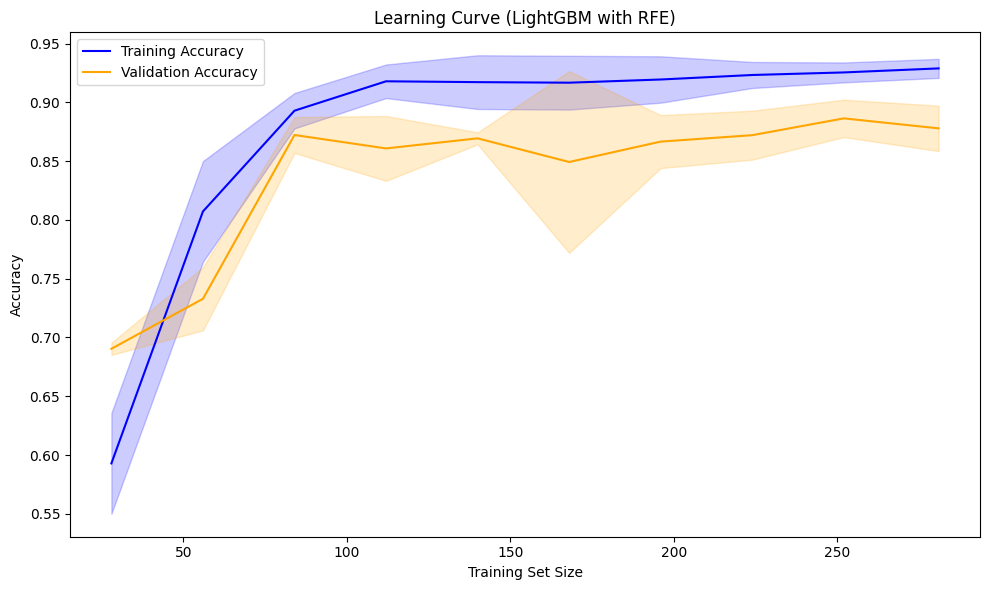

In [81]:
# Prepare LightGBM model for RFE
lgbm_estimator = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=random_seed
)

# Set up RFE with LightGBM as the base estimator
rfe_selector = RFE(estimator=lgbm_estimator, n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Get the mask of selected features
selected_features = rfe_selector.support_
selected_feature_indices = np.where(selected_features)[0]
print(f"Selected features (indices): {selected_feature_indices}")

# Transform the datasets to include only the selected features
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_rfe = lgb.Dataset(X_train_rfe, label=y_train)
d_valid_rfe = lgb.Dataset(X_test_rfe, label=y_test, reference=d_train_rfe)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_rfe,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_rfe,
    num_boost_round=100,
    valid_sets=[d_train_rfe, d_valid_rfe],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob_rfe = lgbm_model.predict(X_test_rfe)
lgbm_y_pred_rfe = (lgbm_y_pred_prob_rfe > 0.5).astype(int)

# Evaluate the model on the test set
accuracy_rfe = accuracy_score(y_test, lgbm_y_pred_rfe)
conf_matrix_rfe = confusion_matrix(y_test, lgbm_y_pred_rfe)
class_report_rfe = classification_report(y_test, lgbm_y_pred_rfe)
mcc_rfe = matthews_corrcoef(y_test, lgbm_y_pred_rfe)

print(f"Test Set Accuracy with RFE: {accuracy_rfe}")
print("Test Set Confusion Matrix with RFE:")
print(conf_matrix_rfe)
print("Test Set Classification Report with RFE:")
print(class_report_rfe)
print(f"Test Set MCC with RFE: {mcc_rfe}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': [X_train.columns[i] for i in selected_feature_indices],  # Use selected features from RFE
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_rfe,                        # Use RFE processed training data
    y_train,                            # Use RFE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + SMOTE

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                   
[22]	cv_agg's valid binary_logloss: 0.364561 + 0.0212926
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:                                             
[70]	cv_agg's valid binary_logloss: 0.372304 + 0.0252915
Training until validation scores don't improve for 10 rounds                   
Early stopping, best iteration is:                                             
[33]	cv_agg's valid binary_logloss: 0.37316 + 0.0286456
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[100]	cv_agg's valid binary_logloss: 0.411123 + 0.0190305
Training until validation scores don't improve for 10 rounds                   
Did not meet early stopping. Best iteration is:                                
[70]	cv_agg's valid binary_logloss: 

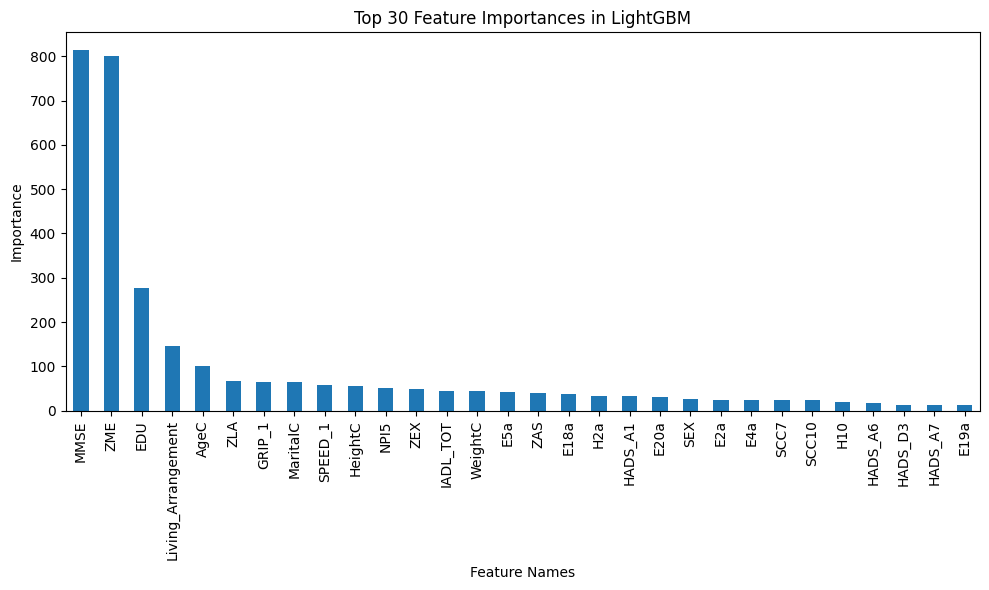

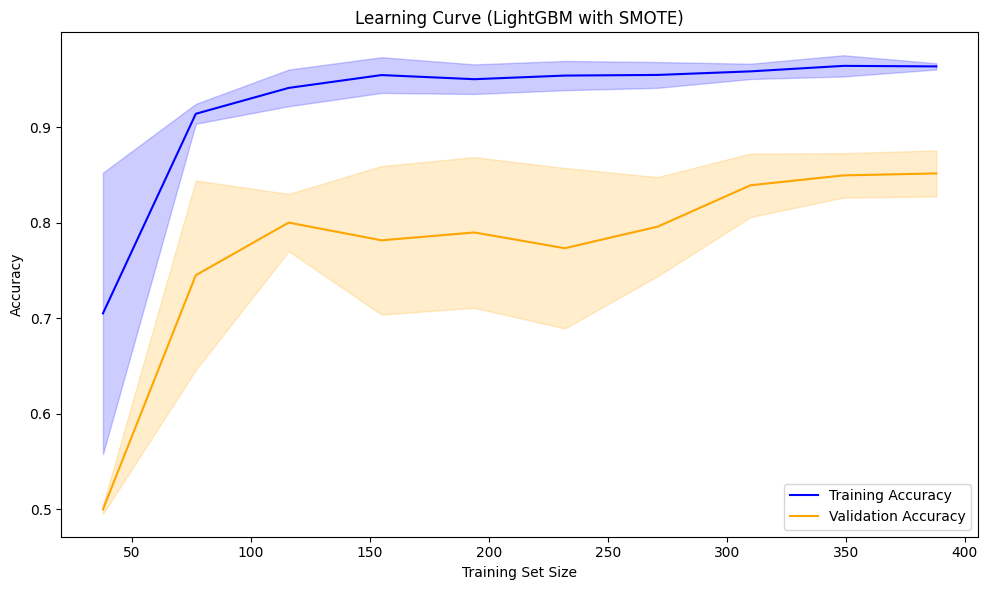

In [82]:
# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_smote = lgb.Dataset(X_train_smote, label=y_train_smote)
d_valid = lgb.Dataset(X_test, label=y_test, reference=d_train_smote)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_smote,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_smote,
    num_boost_round=100,
    valid_sets=[d_train_smote, d_valid],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob = lgbm_model.predict(X_test)
lgbm_y_pred = (lgbm_y_pred_prob > 0.5).astype(int)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, lgbm_y_pred)
conf_matrix = confusion_matrix(y_test, lgbm_y_pred)
class_report = classification_report(y_test, lgbm_y_pred)
mcc = matthews_corrcoef(y_test, lgbm_y_pred)

print(f"Test Set Accuracy: {accuracy}")
print("Test Set Confusion Matrix:")
print(conf_matrix)
print("Test Set Classification Report:")
print(class_report)
print(f"Test Set MCC: {mcc}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_smote,                      # Use SMOTE processed training data
    y_train_smote,                      # Use SMOTE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# LightGBM + RFE + SMOTE

[LightGBM] [Info] Number of positive: 109, number of negative: 243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 352, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.309659 -> initscore=-0.801714
[LightGBM] [Info] Start training from score -0.801714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

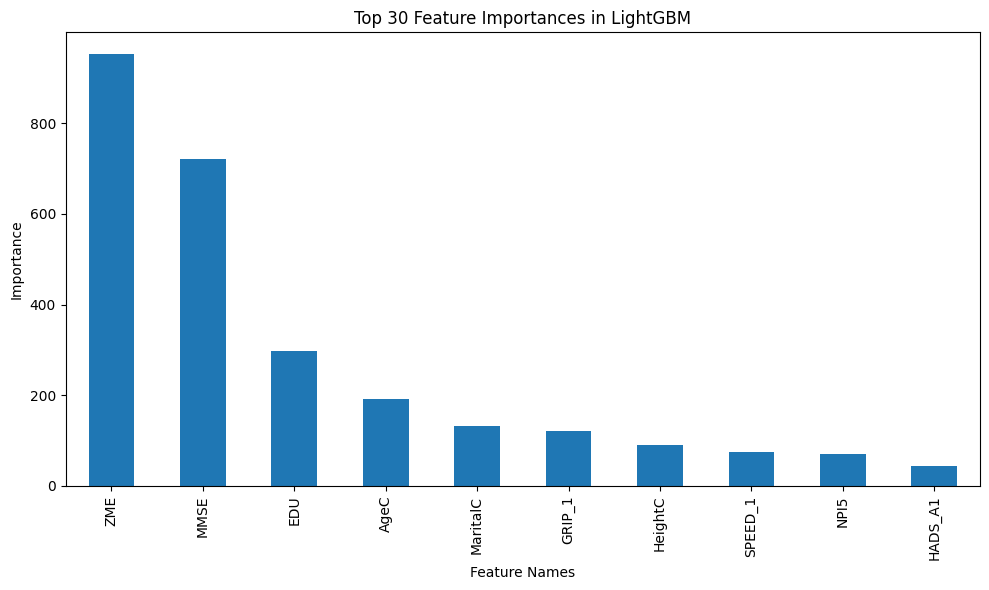

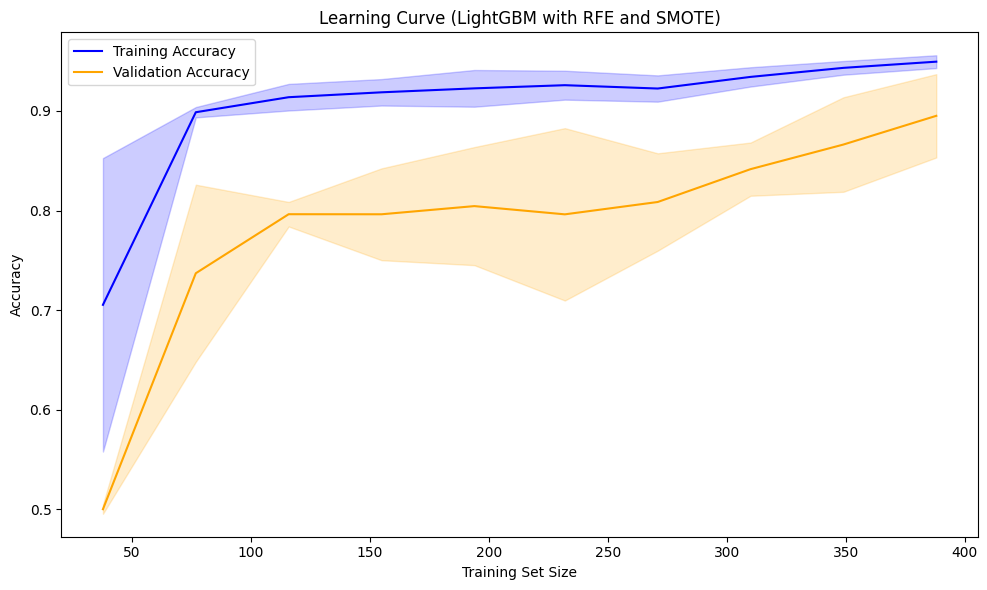

In [83]:
# Prepare LightGBM model for RFE
lgbm_estimator = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=random_seed
)

# Set up RFE with LightGBM as the base estimator
rfe_selector = RFE(estimator=lgbm_estimator, n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X_train, y_train)

# Get the mask of selected features
selected_features = rfe_selector.support_
selected_feature_indices = np.where(selected_features)[0]
print(f"Selected features (indices): {selected_feature_indices}")

# Transform the datasets to include only the selected features
X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Apply SMOTE to the RFE-transformed training data
smote = SMOTE(random_state=random_seed)
X_train_rfe_smote, y_train_rfe_smote = smote.fit_resample(X_train_rfe, y_train)

# Define the search space for Hyperopt
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 10, 120, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4.5, -1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 1, 8, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 30, 1)),
    'lambda_l1': hp.loguniform('lambda_l1', -5, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -5, 0),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 1),
    'num_boost_round': scope.int(hp.quniform('num_boost_round', 50, 300, 10)),
    'verbose': -1,
    'random_state': random_seed
}

# Prepare LightGBM datasets
d_train_rfe_smote = lgb.Dataset(X_train_rfe_smote, label=y_train_rfe_smote)
d_valid_rfe = lgb.Dataset(X_test_rfe, label=y_test, reference=d_train_rfe_smote)

# Define the objective function for Hyperopt
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    num_boost_round = int(params['num_boost_round'])
    del params['num_boost_round']
    
    cv_results = lgb.cv(
        params,
        d_train_rfe_smote,
        num_boost_round=num_boost_round,
        nfold=5,
        stratified=True,
        shuffle=True,
        seed=random_seed,
        metrics='binary_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    logloss_key = 'binary_logloss-mean' if 'binary_logloss-mean' in cv_results else list(cv_results.keys())[0]
    return min(cv_results[logloss_key])

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))
print(f"Best hyperparameters: {best}")

# Use the best hyperparameters to train the final model
best_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': int(best['num_leaves']),
    'learning_rate': best['learning_rate'],
    'feature_fraction': best['feature_fraction'],
    'bagging_fraction': best['bagging_fraction'],
    'bagging_freq': int(best['bagging_freq']),
    'max_depth': int(best['max_depth']),
    'lambda_l1': best['lambda_l1'],
    'lambda_l2': best['lambda_l2'],
    'min_gain_to_split': best['min_gain_to_split'],
    'verbose': -1,
    'random_state': random_seed
}

# Train the LightGBM model
evals_result = {}
lgbm_model = lgb.train(
    best_params,
    d_train_rfe_smote,
    num_boost_round=100,
    valid_sets=[d_train_rfe_smote, d_valid_rfe],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),
        lgb.record_evaluation(evals_result)
    ]
)

# Make predictions on the test set
lgbm_y_pred_prob_rfe_smote = lgbm_model.predict(X_test_rfe)
lgbm_y_pred_rfe_smote = (lgbm_y_pred_prob_rfe_smote > 0.5).astype(int)

# Evaluate the model on the test set
accuracy_rfe_smote = accuracy_score(y_test, lgbm_y_pred_rfe_smote)
conf_matrix_rfe_smote = confusion_matrix(y_test, lgbm_y_pred_rfe_smote)
class_report_rfe_smote = classification_report(y_test, lgbm_y_pred_rfe_smote)
mcc_rfe_smote = matthews_corrcoef(y_test, lgbm_y_pred_rfe_smote)

print(f"Test Set Accuracy with RFE and SMOTE: {accuracy_rfe_smote}")
print("Test Set Confusion Matrix with RFE and SMOTE:")
print(conf_matrix_rfe_smote)
print("Test Set Classification Report with RFE and SMOTE:")
print(class_report_rfe_smote)
print(f"Test Set MCC with RFE and SMOTE: {mcc_rfe_smote}")

# Plot Feature Importance
importance_df = pd.DataFrame({
    'Feature': [X_train.columns[i] for i in selected_feature_indices],  # Use selected features from RFE
    'Importance': lgbm_model.feature_importance(importance_type='gain')  # You can also use 'split'
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance (LightGBM):")
print(importance_df)

# Plot the top 30 features by importance
plt.figure(figsize=(10, 6))
importance_df[:30].set_index('Feature')['Importance'].plot(kind='bar')
plt.title('Top 30 Feature Importances in LightGBM')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Generate the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    lgb.LGBMClassifier(**best_params),  # Use best params for LightGBM
    X_train_rfe_smote,                  # Use RFE + SMOTE processed training data
    y_train_rfe_smote,                  # Use RFE + SMOTE processed labels
    cv=5,  
    scoring='accuracy',                 # Accuracy metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes (10% to 100%)
    random_state=random_seed,           # Random seed for reproducibility
    n_jobs=-1                           # Use all processors
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy', color='orange')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (LightGBM with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# XGBoost

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 12%|█▎        | 1/8 [00:00<00:03,  1.97trial/s, best loss: -0.8323138832997987]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 2/8 [00:00<00:02,  2.15trial/s, best loss: -0.8521931589537225]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 3/8 [00:01<00:01,  2.93trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  2.98trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:00,  3.24trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:01<00:00,  3.48trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:02<00:00,  2.15trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:03<00:00,  2.34trial/s, best loss: -0.8807243460764587]
Best hyperparameters: {'colsample_bytree': np.float64(0.8950326994698486), 'eta': np.float64(0.01355568578855607), 'max_depth': np.float64(20.0), 'min_child_weight': np.float64(8.0), 'n_estimators': np.float64(420.0), 'subsample': np.float64(0.6257147453238197)}
[0]	validation_0-logloss:0.59025
[1]	validation_0-logloss:0.58372
[2]	validation_0-logloss:0.57794
[3]	validation_0-logloss:0.57155
[4]	validation_0-logloss:0.56567
[5]	validation_0-logloss:0.56007
[6]	validation_0-logloss:0.55460
[7]	validation_0-logloss:0.54927
[8]	validation_0-logloss:0.54437
[9]	validation_0-logloss:0.54133
[10]	validation_0-logloss:0.53586
[11]	validation_0-logloss:0.53063
[12]	validation_0-logloss:0.52521
[13]	validation_0-logloss:0.52061
[14]	validation_0-logloss:0.51591
[15]	validation_0-logloss:0.51147
[16]	validation_0-logloss:0.50724
[17]	validation_0-logloss:0.50302
[18]	validation_0-logloss:0.49875
[19]	validation_0-lo

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[78]	validation_0-logloss:0.36226
[79]	validation_0-logloss:0.36076
[80]	validation_0-logloss:0.35933
[81]	validation_0-logloss:0.35828
[82]	validation_0-logloss:0.35697
[83]	validation_0-logloss:0.35617
[84]	validation_0-logloss:0.35504
[85]	validation_0-logloss:0.35394
[86]	validation_0-logloss:0.35262
[87]	validation_0-logloss:0.35129
[88]	validation_0-logloss:0.35024
[89]	validation_0-logloss:0.34927
[90]	validation_0-logloss:0.34822
[91]	validation_0-logloss:0.34706
[92]	validation_0-logloss:0.34615
[93]	validation_0-logloss:0.34531
[94]	validation_0-logloss:0.34468
[95]	validation_0-logloss:0.34402
[96]	validation_0-logloss:0.34301
[97]	validation_0-logloss:0.34202
[98]	validation_0-logloss:0.34076
[99]	validation_0-logloss:0.33966
[100]	validation_0-logloss:0.33863
[101]	validation_0-logloss:0.33757
[102]	validation_0-logloss:0.33684
[103]	validation_0-logloss:0.33647
[104]	validation_0-logloss:0.33575
[105]	validation_0-logloss:0.33446
[106]	validation_0-logloss:0.33348
[107]	v

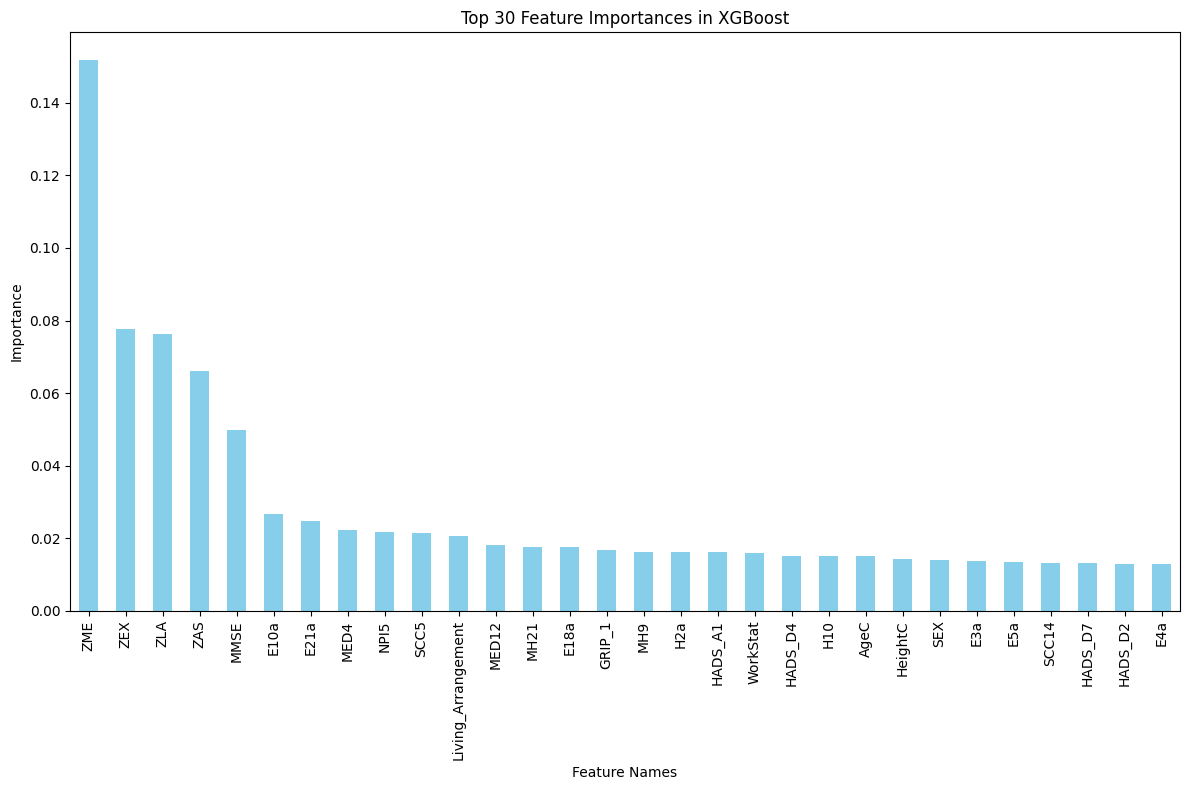

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

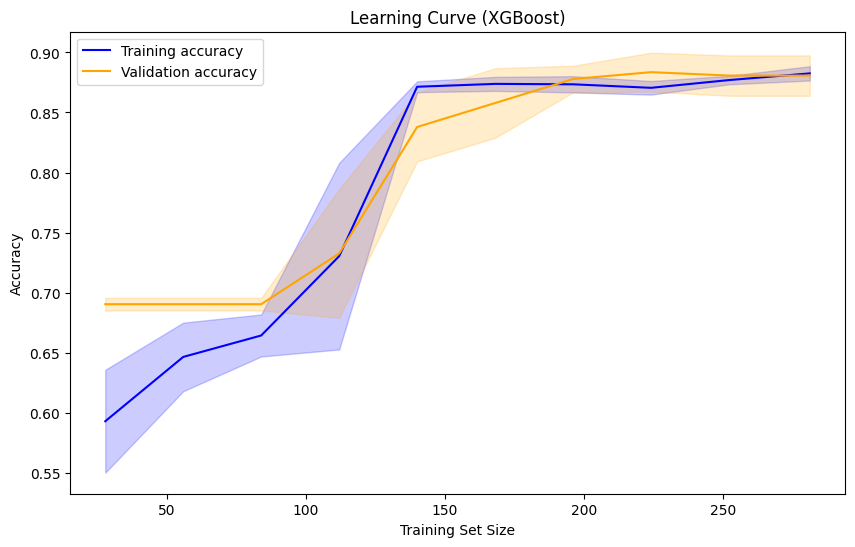

In [84]:
# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1,
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# XGBoost + RFE

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features: ['IADL_TOT', 'Living_Arrangement', 'MED4', 'H2b', 'MH3', 'SCC5', 'HADS_A1', 'E16a', 'ZEX', 'MH21', 'E5a', 'E20a', 'MED12', 'SCC6', 'H2a', 'SPEED_1', 'H5', 'MED9', 'MED1', 'ZME', 'MH7', 'ZLA', 'EDU', 'E2a', 'ZAS', 'WeightC', 'ΜaritalC', 'GRIP_1', 'SCC13', 'HADS_D4']
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

 12%|█▎        | 1/8 [00:00<00:02,  3.41trial/s, best loss: -0.8496177062374246]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:00<00:01,  4.73trial/s, best loss: -0.8778672032193159]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:00<00:00,  4.71trial/s, best loss: -0.8807243460764587]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:00,  4.67trial/s, best loss: -0.8807243460764587]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:01<00:00,  5.08trial/s, best loss: -0.8807243460764587]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:01<00:00,  3.03trial/s, best loss: -0.8862374245472837]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:02<00:00,  3.51trial/s, best loss: -0.8862374245472837]
Best hyperparameters: {'colsample_bytree': np.float64(0.9790830954612103), 'eta': np.float64(0.08467406425814078), 'max_depth': np.float64(44.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(500.0), 'subsample': np.float64(0.8796314378966033)}
[0]	validation_0-logloss:0.56091
[1]	validation_0-logloss:0.52827
[2]	validation_0-logloss:0.50405
[3]	validation_0-logloss:0.47861
[4]	validation_0-logloss:0.46332
[5]	validation_0-logloss:0.45124
[6]	validation_0-logloss:0.43819
[7]	validation_0-logloss:0.42381
[8]	validation_0-logloss:0.41746
[9]	validation_0-logloss:0.40950
[10]	validation_0-logloss:0.40270
[11]	validation_0-logloss:0.39789
[12]	validation_0-logloss:0.39127
[13]	validation_0-logloss:0.38474
[14]	validation_0-logloss:0.38221
[15]	validation_0-logloss:0.37754
[16]	validation_0-logloss:0.37343
[17]	validation_0-logloss:0.37109
[18]	validation_0-logloss:0.36571
[19]	validation_0-lo

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Set Accuracy: 0.8539325842696629
Test Set Confusion Matrix:
[[55  9]
 [ 4 21]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89        64
           1       0.70      0.84      0.76        25

    accuracy                           0.85        89
   macro avg       0.82      0.85      0.83        89
weighted avg       0.87      0.85      0.86        89

Test Set MCC: 0.6649415355974628


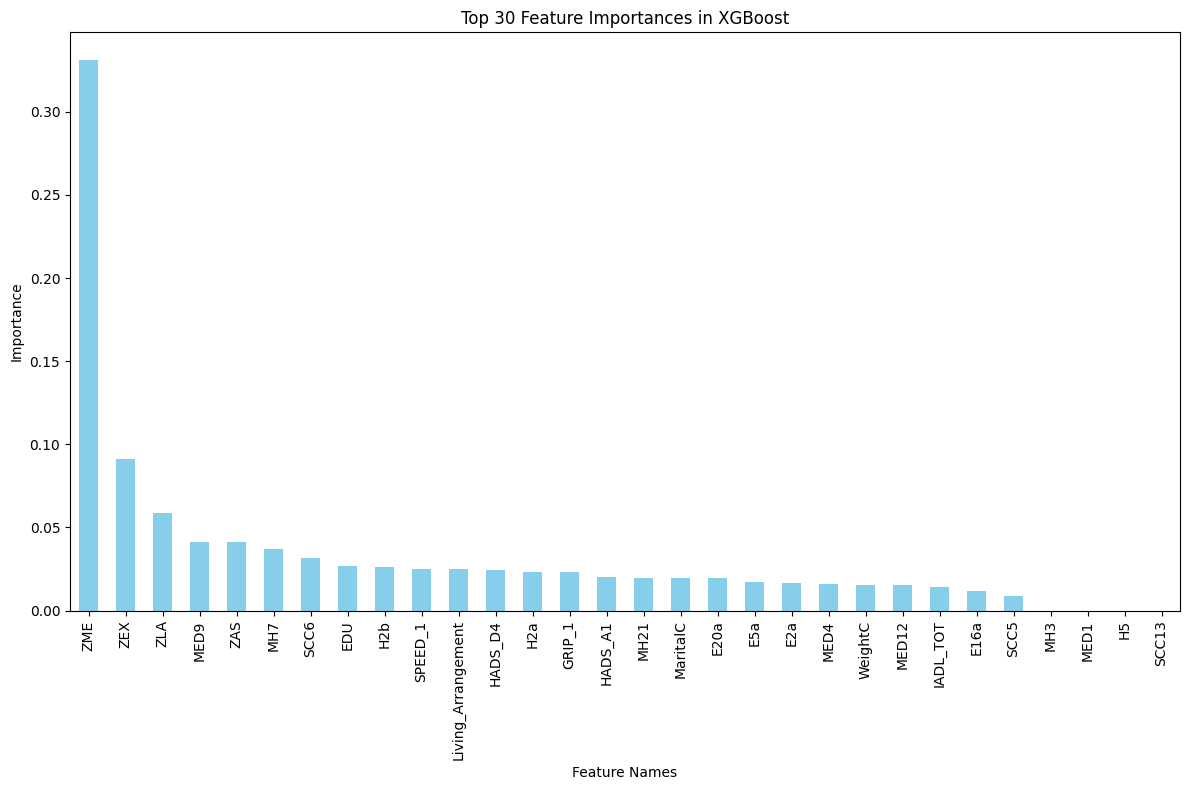

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

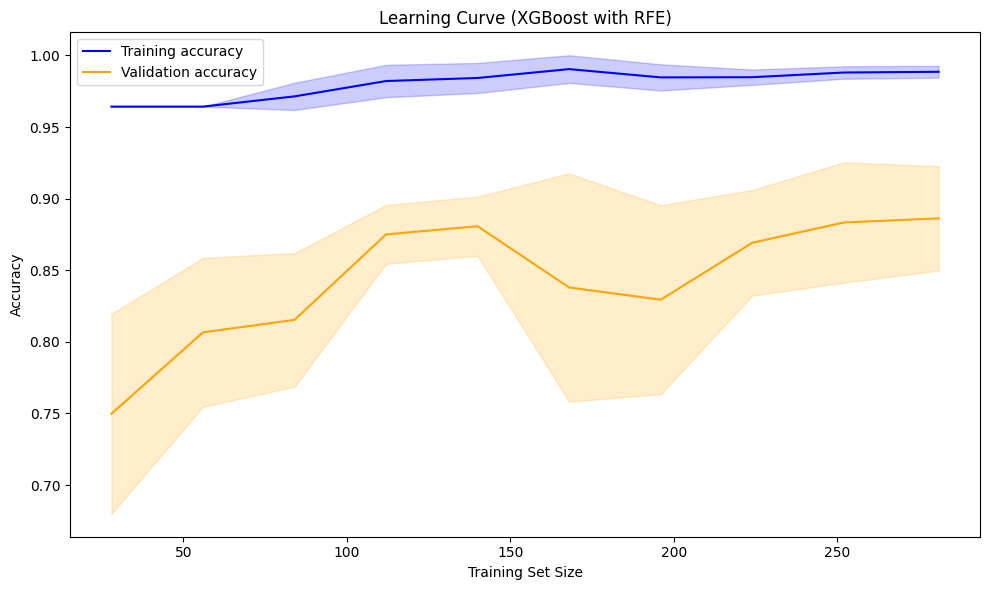

In [87]:
# RFE
base_model = XGBClassifier(random_state=random_seed, use_label_encoder=False)
rfe = RFE(estimator=base_model, n_features_to_select=30, step=1) 
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_rfe, y_train, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_rfe, y_train, eval_set=[(X_test_rfe, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test_rfe)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train_rfe.columns
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_rfe,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



# XGBoost + SMOTE

  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 12%|█▎        | 1/8 [00:00<00:03,  1.97trial/s, best loss: -0.8312855038922786]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 25%|██▌       | 2/8 [00:00<00:02,  2.06trial/s, best loss: -0.8312855038922786]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 38%|███▊      | 3/8 [00:01<00:01,  2.74trial/s, best loss: -0.8477803492531034]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  2.71trial/s, best loss: -0.8477803492531034]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:01,  2.90trial/s, best loss: -0.8477803492531034]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:02<00:00,  3.14trial/s, best loss: -0.8477803492531034]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:03<00:00,  1.90trial/s, best loss: -0.8539448769198401]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

100%|██████████| 8/8 [00:03<00:00,  2.11trial/s, best loss: -0.8539448769198401]
Best hyperparameters: {'colsample_bytree': np.float64(0.9790830954612103), 'eta': np.float64(0.08467406425814078), 'max_depth': np.float64(44.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(500.0), 'subsample': np.float64(0.8796314378966033)}
[0]	validation_0-logloss:0.65267
[1]	validation_0-logloss:0.61976
[2]	validation_0-logloss:0.58859
[3]	validation_0-logloss:0.56182
[4]	validation_0-logloss:0.53227
[5]	validation_0-logloss:0.51289
[6]	validation_0-logloss:0.49614
[7]	validation_0-logloss:0.48113
[8]	validation_0-logloss:0.46646
[9]	validation_0-logloss:0.45057
[10]	validation_0-logloss:0.44002
[11]	validation_0-logloss:0.42880
[12]	validation_0-logloss:0.42163
[13]	validation_0-logloss:0.41594
[14]	validation_0-logloss:0.41061
[15]	validation_0-logloss:0.40400
[16]	validation_0-logloss:0.40012
[17]	validation_0-logloss:0.39377
[18]	validation_0-logloss:0.38791
[19]	validation_0-lo

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[44]	validation_0-logloss:0.33083
[45]	validation_0-logloss:0.33027
[46]	validation_0-logloss:0.32992
[47]	validation_0-logloss:0.32611
[48]	validation_0-logloss:0.32461
[49]	validation_0-logloss:0.32253
[50]	validation_0-logloss:0.32358
[51]	validation_0-logloss:0.32504
[52]	validation_0-logloss:0.32580
[53]	validation_0-logloss:0.32662
[54]	validation_0-logloss:0.32589
[55]	validation_0-logloss:0.32630
[56]	validation_0-logloss:0.32303
[57]	validation_0-logloss:0.32424
[58]	validation_0-logloss:0.32087
[59]	validation_0-logloss:0.32138
[60]	validation_0-logloss:0.32111
[61]	validation_0-logloss:0.32249
[62]	validation_0-logloss:0.32203
[63]	validation_0-logloss:0.32361
[64]	validation_0-logloss:0.32300
[65]	validation_0-logloss:0.32190
[66]	validation_0-logloss:0.32394
[67]	validation_0-logloss:0.32559
[68]	validation_0-logloss:0.32757
Test Set Accuracy: 0.8764044943820225
Test Set Confusion Matrix:
[[54 10]
 [ 1 24]]
Test Set Classification Report:
              precision    recall 

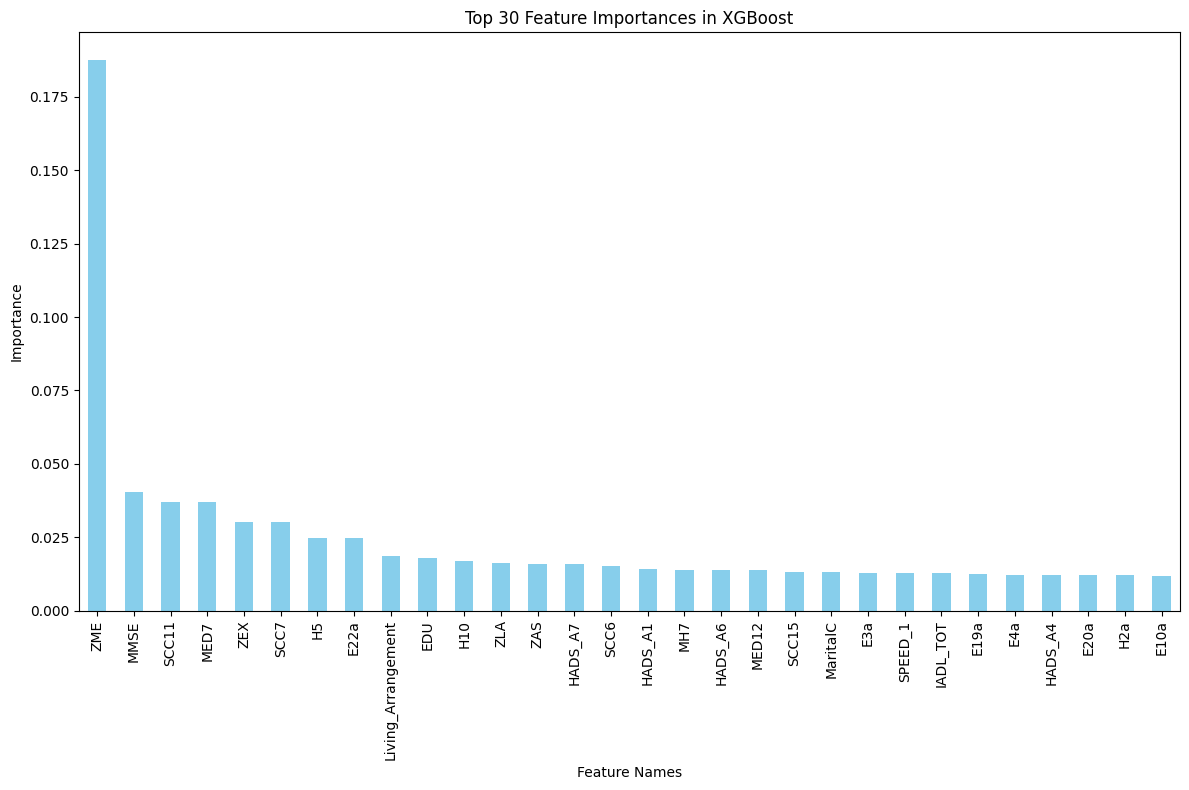

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

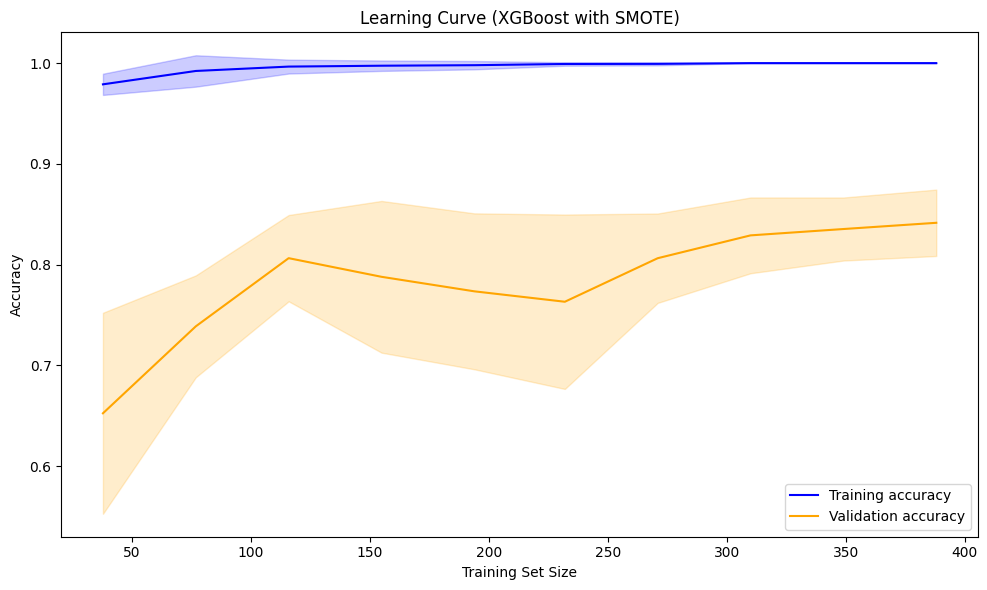

In [88]:
# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Remove `early_stopping_rounds` for the learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

# Generate the learning curve
train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# XGBoost + RFE + SMOTE

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

Selected features: ['IADL_TOT', 'Living_Arrangement', 'MED4', 'H2b', 'MH3', 'SCC5', 'HADS_A1', 'E16a', 'ZEX', 'MH21', 'E5a', 'E20a', 'MED12', 'SCC6', 'H2a', 'SPEED_1', 'H5', 'MED9', 'MED1', 'ZME', 'MH7', 'ZLA', 'EDU', 'E2a', 'ZAS', 'WeightC', 'ΜaritalC', 'GRIP_1', 'SCC13', 'HADS_D4']
  0%|          | 0/8 [00:00<?, ?trial/s, best loss=?]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 12%|█▎        | 1/8 [00:00<00:02,  2.99trial/s, best loss: -0.8168104355144118]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 2/8 [00:00<00:01,  3.02trial/s, best loss: -0.82705659583421]  

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 38%|███▊      | 3/8 [00:00<00:01,  4.11trial/s, best loss: -0.8311592678308436]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 50%|█████     | 4/8 [00:01<00:01,  3.99trial/s, best loss: -0.8373869135282981]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 62%|██████▎   | 5/8 [00:01<00:00,  4.30trial/s, best loss: -0.8414895855249316]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 75%|███████▌  | 6/8 [00:01<00:00,  4.68trial/s, best loss: -0.8497370082053439]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_labe

 88%|████████▊ | 7/8 [00:02<00:00,  2.57trial/s, best loss: -0.8682095518619819]

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 8/8 [00:02<00:00,  2.99trial/s, best loss: -0.8682095518619819]
Best hyperparameters: {'colsample_bytree': np.float64(0.9790830954612103), 'eta': np.float64(0.08467406425814078), 'max_depth': np.float64(44.0), 'min_child_weight': np.float64(2.0), 'n_estimators': np.float64(500.0), 'subsample': np.float64(0.8796314378966033)}
[0]	validation_0-logloss:0.65678


/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-logloss:0.62722
[2]	validation_0-logloss:0.59651
[3]	validation_0-logloss:0.57167
[4]	validation_0-logloss:0.54972
[5]	validation_0-logloss:0.52909
[6]	validation_0-logloss:0.51311
[7]	validation_0-logloss:0.49878
[8]	validation_0-logloss:0.48912
[9]	validation_0-logloss:0.48046
[10]	validation_0-logloss:0.47317
[11]	validation_0-logloss:0.46629
[12]	validation_0-logloss:0.46140
[13]	validation_0-logloss:0.45725
[14]	validation_0-logloss:0.45447
[15]	validation_0-logloss:0.45157
[16]	validation_0-logloss:0.44820
[17]	validation_0-logloss:0.44799
[18]	validation_0-logloss:0.44569
[19]	validation_0-logloss:0.44560
[20]	validation_0-logloss:0.44501
[21]	validation_0-logloss:0.44270
[22]	validation_0-logloss:0.44119
[23]	validation_0-logloss:0.43975
[24]	validation_0-logloss:0.43668
[25]	validation_0-logloss:0.43614
[26]	validation_0-logloss:0.43853
[27]	validation_0-logloss:0.43884
[28]	validation_0-logloss:0.43776
[29]	validation_0-logloss:0.43743
[30]	validation_0-loglo

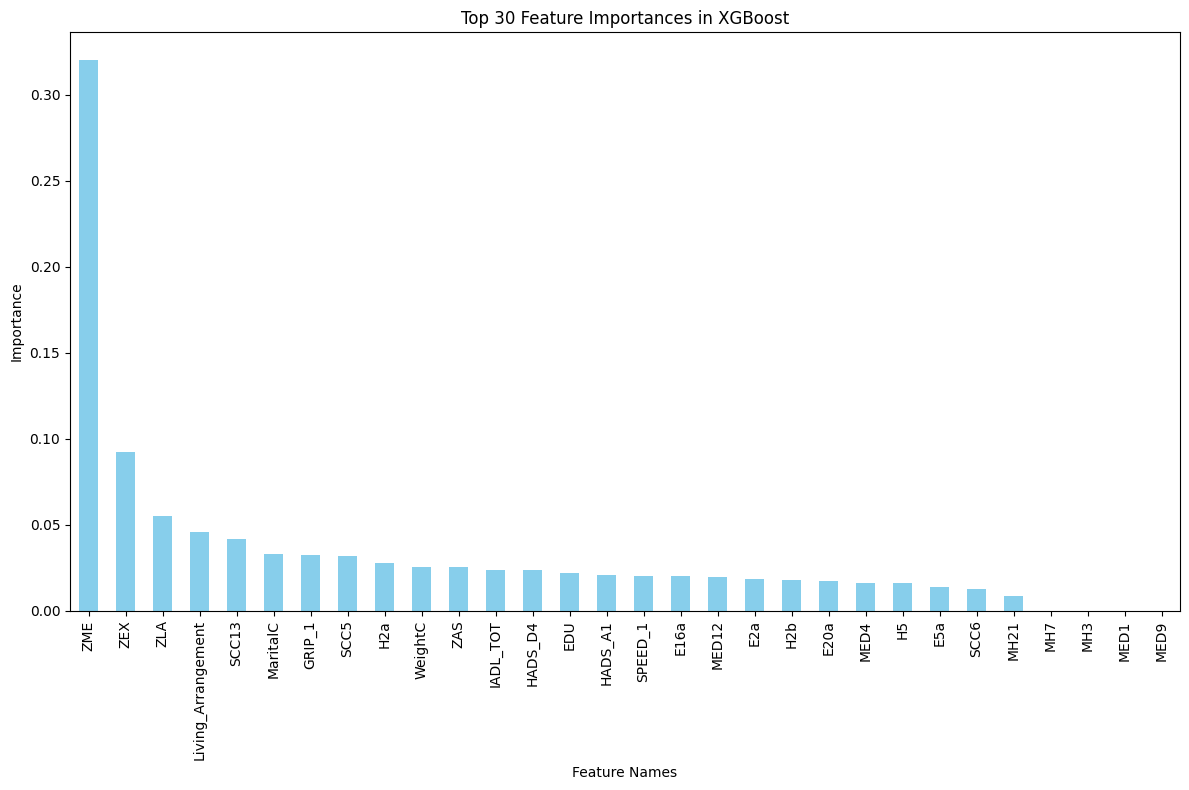

/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/andyhuang/Desktop/dementia/envdm/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:33:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

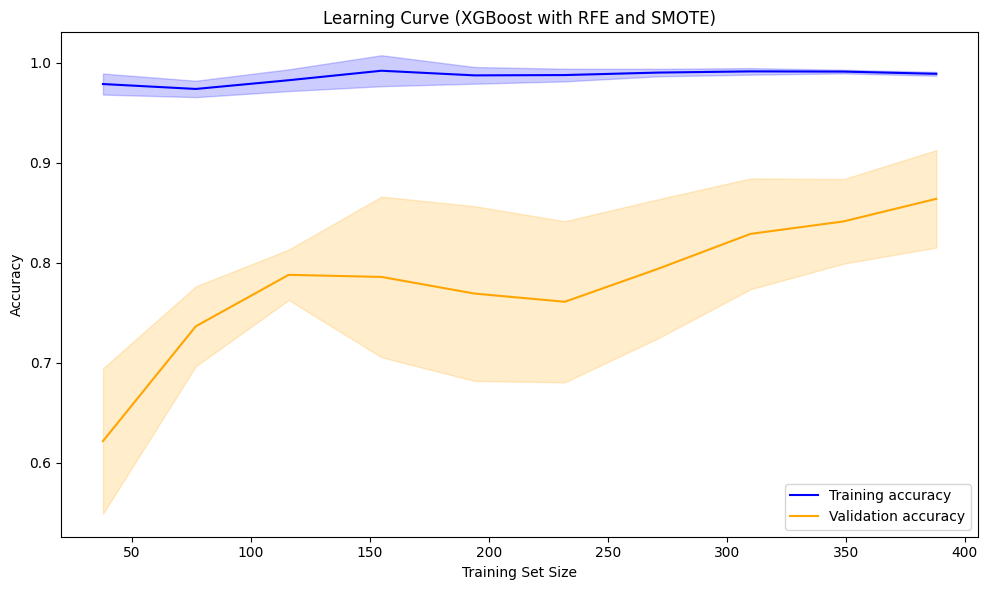

In [89]:
# Apply RFE 
base_model = XGBClassifier(random_state=random_seed, use_label_encoder=False)
rfe = RFE(estimator=base_model, n_features_to_select=30, step=1) 
rfe.fit(X_train, y_train)

# Update training and test sets with selected features
X_train_rfe = X_train.iloc[:, rfe.support_]
X_test_rfe = X_test.iloc[:, rfe.support_]

print(f"Selected features: {list(X_train_rfe.columns)}")

# Apply SMOTE 
smote = SMOTE(random_state=random_seed)
X_train_rfe_smote, y_train_smote = smote.fit_resample(X_train_rfe, y_train)

# Define the objective function for Hyperopt
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        random_state=random_seed,
        verbosity=1
    )
    # Perform cross-validation
    scores = cross_val_score(model, X_train_rfe_smote, y_train_smote, cv=5, scoring='accuracy')
    return -np.mean(scores)

# Define the search space for XGBClassifier parameters
space = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 50, 1)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 10)),
}

# Run the optimization with Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=8, trials=trials, rstate=np.random.default_rng(random_seed))

print(f"Best hyperparameters: {best}")

# Convert the best params for training
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'n_estimators': int(best['n_estimators']),
    'random_state': random_seed,
    'use_label_encoder': False,
    'early_stopping_rounds': 10,
}

# Train the model
model_all_visits = XGBClassifier(**best_params)
model_all_visits.fit(X_train_rfe_smote, y_train_smote, eval_set=[(X_test_rfe, y_test)], verbose=True)

# Make predictions
y_pred_prob_model_all_visits = model_all_visits.predict_proba(X_test_rfe)[:, 1]
y_pred_model_all_visits = (y_pred_prob_model_all_visits > 0.5).astype(int)

# Evaluate the model
accuracy_model_all_visits = accuracy_score(y_test, y_pred_model_all_visits)
conf_matrix_model_all_visits = confusion_matrix(y_test, y_pred_model_all_visits)
class_report_model_all_visits = classification_report(y_test, y_pred_model_all_visits)
mcc_model_all_visits = matthews_corrcoef(y_test, y_pred_model_all_visits)

print(f"Test Set Accuracy: {accuracy_model_all_visits}")
print("Test Set Confusion Matrix:")
print(conf_matrix_model_all_visits)
print("Test Set Classification Report:")
print(class_report_model_all_visits)
print(f"Test Set MCC: {mcc_model_all_visits}")

# Feature importance analysis
feature_importances_model_all_visits = model_all_visits.feature_importances_
feature_names_model_all_visits = X_train_rfe.columns
feat_importances_model_all_visits = pd.Series(feature_importances_model_all_visits, index=feature_names_model_all_visits)
feat_importances_model_all_visits = feat_importances_model_all_visits.sort_values(ascending=False)

# Plot top 30 feature importances
plt.figure(figsize=(12, 8))
feat_importances_model_all_visits[:30].plot(kind='bar', color='skyblue')
plt.title('Top 30 Feature Importances in XGBoost')
plt.ylabel('Importance')
plt.xlabel('Feature Names')
plt.tight_layout()
plt.show()

# Learning curve
params_for_learning_curve_model_all_visits = {key: value for key, value in best_params.items() if key != 'early_stopping_rounds'}

train_sizes_model_all_visits, train_scores_model_all_visits, val_scores_model_all_visits = learning_curve(
    XGBClassifier(**params_for_learning_curve_model_all_visits),
    X_train_rfe_smote,
    y_train_smote,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=random_seed
)

# Calculate means and standard deviations
train_scores_mean = np.mean(train_scores_model_all_visits, axis=1)
train_scores_std = np.std(train_scores_model_all_visits, axis=1)
val_scores_mean = np.mean(val_scores_model_all_visits, axis=1)
val_scores_std = np.std(val_scores_model_all_visits, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_model_all_visits, train_scores_mean, label='Training accuracy', color='blue')
plt.fill_between(train_sizes_model_all_visits, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes_model_all_visits, val_scores_mean, label='Validation accuracy', color='orange')
plt.fill_between(train_sizes_model_all_visits, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='orange')
plt.title('Learning Curve (XGBoost with RFE and SMOTE)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
